# **🦜 COS30082 Applied Machine Learning**  <br> **🧠 Individual Assignment 1**
---
## **Bird Species Classification:** Caltech-UCSD Birds 200 (CUB-200)  

**Prepared by:** Deron Yijia FOO (102780757)  

**Prepared for:** Ts Dr Lee Sue Han  

**Due Date**: 24 October 2025 by 23:59

*Semester 2, 2025*

---

#**1.0 🧩 Setup and Configuration**

> This first section configures the entire environment by setting up storage, installing all dependencies, importing libraries, and ensuring reproducibility on the selected hardware.

In [ ]:
# --- 1️⃣ Environment Setup ---
# Mount Google Drive for persistent storage.
from google.colab import drive
drive.mount('/content/drive') # Connects Google Drive to the local filesystem at /content/drive

Mounted at /content/drive


In [ ]:
import os  # Standard library for interacting with the operating system.

# Ensure the 'setup' directory exists to store configuration files.
os.makedirs("setup", exist_ok=True)

requirements = """\
# ==================================
# Core Deep Learning Framework
# ==================================
torch
torchvision
torchaudio

# ==================================
# Data Manipulation & Analysis
# ==================================
numpy
pandas
scikit-learn

# ==================================
# Computer Vision & Image Processing
# ==================================
Pillow
opencv-python

# ==================================
# Model Architectures & Analysis
# ==================================
timm
torchsummary

# ==================================
# Visualisation & Plotting
# ==================================
matplotlib
seaborn
plotly

# ==================================
# Interactive App & Deployment
# ==================================
gradio

# ==================================
# Experiment Tracking & Logging
# ==================================
wandb

# ==================================
# System & Utility Tools
# ==================================
tqdm
gdown
psutil
"""

# Generate the requirements file with dependencies categorised by function.
with open("setup/requirements.txt", "w") as f:
    f.write(requirements)

print("✅ requirements.txt successfully created!")

✅ requirements.txt successfully created!


In [ ]:
# --- 2️⃣ Dependency Installation ---
# Install all categorised libraries listed in the requirements file silently.
!pip install -r setup/requirements.txt --quiet

print("✅ All required packages installed successfully.")

✅ All required packages installed successfully.


In [ ]:
# --- 3️⃣ Import Libraries & Environment Configuration ---

# 🧠 Core Deep Learning Framework (PyTorch)
# Contains core tensor operations, modules, and data utilities.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast # For mixed precision training
import torchvision
from torchvision import transforms, datasets, models

# 🧬 Model Architectures & Analysis
import timm # PyTorch Image Models (state-of-the-art architectures)
from torchsummary import summary # View model layer sizes and parameter counts

# 📊 Data Manipulation & File Handling
import numpy as np
import pandas as pd
import zipfile
import gdown # Utility for downloading files from Google Drive/public URLs

# 🖼️ Image Processing & Computer Vision
from PIL import Image # Python Imaging Library
import cv2 # OpenCV

# 🎨 Visualisation & Reporting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 📈 Evaluation & Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support,
    accuracy_score,
    top_k_accuracy_score,
)


# ⚙️ System Utilities & Standard Helpers
from tqdm import tqdm # Progress bar functionality
import psutil # System information (CPU, memory monitoring)
import os
import random
import time
import re
import json
import math
import copy
from pprint import pprint # Pretty-print for clean output

# 🌐 Interactive Web Deployment
import gradio as gr

In [ ]:
# --- 4️⃣ Reproducibility and Hardware Setup ---

# 🧪 Set Global Random Seeds for Experiment Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Configure CUDA backend for deterministic behaviour
torch.backends.cudnn.deterministic = True
# Disable automatic benchmarking (prevents random changes in performance)
torch.backends.cudnn.benchmark = False

# 🖥️ Device Selection: Prioritise CUDA GPU if available, otherwise default to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Report Configuration Summary ---
print("===============================================")
print("✅ Setup and Configuration Complete!")
print("Torch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Device in Use:", device)
print("Number of CPU Cores:", psutil.cpu_count(logical=True))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
print("===============================================")

✅ Setup and Configuration Complete!
Torch Version: 2.8.0+cu126
Torchvision Version: 0.23.0+cu126
CUDA Available: False
Device in Use: cpu
Number of CPU Cores: 2


# **2.0 📦 Dataset Handling**

> This second section comprehensively addresses the CUB-200 dataset by setting up paths and downloading data, conducting integrity checks and imbalance analysis (ratio 1.94), designing mild augmentation pipelines to prevent overfitting, and finally creating the custom PyTorch Dataset and DataLoaders for model consumption.

## &emsp;&emsp;**2.1 🗃️ Data Loading and Preparation**

> This subsection configures dataset paths, implements a fail-safe download and extraction of the zipped image and annotation files from Google Drive, loads the annotation data into Pandas DataFrames, and ensures a complete class-to-label mapping is available.


In [ ]:
# --- 1️⃣ Dataset Path Configuration and Directory Setup ---

# 🌐 Remote Source IDs (Google Drive)
# IDs for the dataset and annotation files, used for fallback download via gdown.
train_id = "1jkmNheY96g_4Dq-kIek-nFjgFNbLTGBw"
test_id = "17c05lnNbs_pXQm3i3gQU1bgeMEfypW3p"
train_anno_id = "1WCZlz0rqnljH_B27lewbkEuzdljtV594"
test_anno_id = "1nnHFNTGVg6I75noKZj1XYYLs9LBQJiYh"
classes_id = "1CR8QrPZNyjO6sCTVQpTQ1sPaFH8-Q5mc"

# Construct download URLs using the file IDs
train_url = f"https://drive.google.com/uc?id={train_id}"
test_url = f"https://drive.google.com/uc?id={test_id}"
train_anno_url = f"https://drive.google.com/uc?id={train_anno_id}"
test_anno_url = f"https://drive.google.com/uc?id={test_anno_id}"
classes_url = f"https://drive.google.com/uc?id={classes_id}"

# 💾 Local Paths (Expected location on mounted Google Drive)
# Define the base directory on Drive and specific file paths.
local_base = '/content/drive/MyDrive/COS30082 Applied Machine Learning'
local_files = {
    "train_zip": os.path.join(local_base, "Train.zip"),
    "test_zip": os.path.join(local_base, "Test.zip"),
    "train_txt": os.path.join(local_base, "train.txt"),
    "test_txt": os.path.join(local_base, "test.txt"),
    "classes_txt": os.path.join(local_base, "classes.txt"),
}

# 📁 Target Directories
# Create the temporary directory where dataset contents will be extracted.
extraction_dir = '/content/extracted_dataset'
os.makedirs(extraction_dir, exist_ok=True)

In [ ]:
# --- 2️⃣ Helper Function: Dataset Management ---
def safe_extract(zip_path, download_url, target_dir, name):
    """
    Attempts to extract a ZIP file from the local path (Drive). If not found,
    it falls back to downloading the file from the Google Drive URL using gdown.
    """
    if os.path.exists(zip_path):
        # Local file found: proceed with extraction from the mounted Drive path
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"✅ Extracted local {name} → {target_dir}")
    else:
        # Local file not found: trigger download fallback
        print(f"⚠️ Local {name} ZIP not found. Initiating download from Google Drive...")
        out_path = os.path.join(target_dir, f"{name}.zip")

        # Download the file, saving it directly to the target directory
        gdown.download(download_url, out_path, quiet=False)

        # Extract the newly downloaded file
        with zipfile.ZipFile(out_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"✅ Downloaded & extracted {name} dataset → {target_dir}")

# --- 3️⃣ Execute Dataset Extraction ---

# Process the Training and Testing datasets using the defined logic.
safe_extract(local_files["train_zip"], train_url, extraction_dir, "Train")
safe_extract(local_files["test_zip"], test_url, extraction_dir, "Test")

✅ Extracted local Train → /content/extracted_dataset
✅ Extracted local Test → /content/extracted_dataset


In [ ]:
# --- 4️⃣ Annotation and Class File Setup ---

# Ensure Annotation Files (train.txt/test.txt) Exist
# Prioritise local files from Google Drive, falling back to download if missing.
for label_name, url in {
    "train.txt": train_anno_url,
    "test.txt": test_anno_url,
}.items():
    local_path = local_files[label_name.replace('.', '_')] # e.g., local_files["train_txt"]
    dest_path = os.path.join(extraction_dir, label_name)

    if os.path.exists(local_path):
        # Local annotation file found on Drive
        print(f"📄 Found local {label_name} on Drive.")

    if not os.path.exists(dest_path):
        # File not in final destination (or wasn't on Drive/copied). Download is required.
        print(f"⚠️ Missing {label_name}. Downloading from Google Drive...")
        gdown.download(url, dest_path, quiet=False)
        print(f"✅ Downloaded {label_name} to {dest_path}")
    else:
        print(f"📄 Annotation {label_name} ready at {dest_path}")

# Download or Generate Classes File (classes.txt)
classes_path = os.path.join(extraction_dir, "classes.txt")
train_txt_path = os.path.join(extraction_dir, "train.txt")

if not os.path.exists(classes_path):
    # Attempt 1: Download classes.txt if available remotely
    try:
        print("\nAttempting to download classes.txt...")
        gdown.download(classes_url, classes_path, quiet=False)
        print(f"✅ Downloaded classes.txt")

    except Exception as e:
        # Fallback 2: Generate classes.txt from the training annotations
        print("\n⚠️ classes.txt not found. Generating class mapping from train.txt...")

        if not os.path.exists(train_txt_path):
            raise FileNotFoundError(f"❌ train.txt not found at {train_txt_path}. Cannot generate classes.txt.")

        # Load annotation data: [image_path, class_id]
        temp_df = pd.read_csv(train_txt_path, sep=" ", header=None, names=["image_path", "class_id"])

        # Function to extract the descriptive class name (e.g., 'Flycatcher_0001.jpg' -> 'Flycatcher')
        def extract_class_name(filename):
            base = os.path.basename(filename)
            base = os.path.splitext(base)[0]
            # Match class prefix (letters/underscores) before the first numerical index
            match = re.match(r"([A-Za-z_]+?)(?:_\d|$)", base)
            return match.group(1) if match else base

        temp_df["class_name"] = temp_df["image_path"].apply(extract_class_name)

        # Generate final unique mapping (class_id and class_name)
        classes_df = temp_df.drop_duplicates(subset=["class_id", "class_name"]).sort_values(by="class_id")
        classes_df = classes_df[["class_id", "class_name"]]

        # Save the mapping as a space-separated file
        classes_df.to_csv(classes_path, sep=" ", header=False, index=False)
        print(f"✅ Created classes.txt with {len(classes_df)} unique classes at: {classes_path}")

        if classes_df["class_id"].duplicated().any():
            print("⚠️ Warning: Duplicate class IDs detected in classes.txt generation!")

        print("🪶 Sample of generated class mapping:")
        print(classes_df.head(5).to_string(index=False))

else:
    print("📄 Existing classes.txt found; skipping generation.")

📄 Found local train.txt on Drive.
⚠️ Missing train.txt. Downloading from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1WCZlz0rqnljH_B27lewbkEuzdljtV594
To: /content/extracted_dataset/train.txt
100%|██████████| 196k/196k [00:00<00:00, 73.2MB/s]


✅ Downloaded train.txt to /content/extracted_dataset/train.txt
📄 Found local test.txt on Drive.
⚠️ Missing test.txt. Downloading from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1nnHFNTGVg6I75noKZj1XYYLs9LBQJiYh
To: /content/extracted_dataset/test.txt
100%|██████████| 16.2k/16.2k [00:00<00:00, 24.0MB/s]


✅ Downloaded test.txt to /content/extracted_dataset/test.txt

Attempting to download classes.txt...


Downloading...
From: https://drive.google.com/uc?id=1CR8QrPZNyjO6sCTVQpTQ1sPaFH8-Q5mc
To: /content/extracted_dataset/classes.txt
100%|██████████| 4.02k/4.02k [00:00<00:00, 6.34MB/s]

✅ Downloaded classes.txt


In [ ]:
# --- 5️⃣ Annotation Data Loading (DataFrames) ---

def load_annotations(file_path, split_name):
    """
    Loads a space-separated annotation file into a Pandas DataFrame.

    The DataFrame contains image paths, class IDs, and an added 'split' column
    to identify the data subset (train or test).
    """
    # Read the file using the space delimiter and assign column headers
    df = pd.read_csv(file_path, sep=" ", header=None, names=["image_path", "class_id"])

    # Add a column identifying the data split (e.g., 'train')
    df["split"] = split_name
    return df

# Load the training annotation file and assign the 'train' split
train_df = load_annotations(os.path.join(extraction_dir, "train.txt"), "train")

# Load the testing annotation file and assign the 'test' split
test_df = load_annotations(os.path.join(extraction_dir, "test.txt"), "test")

print(f"Loaded train_df with {len(train_df)} entries.")
print(f"Loaded test_df with {len(test_df)} entries.")

Loaded train_df with 4829 entries.
Loaded test_df with 1204 entries.


In [ ]:
# --- 6️⃣ Class Name Processing and Integration ---

def clean_class_name(name):
    """Normalises raw class names by removing punctuation and standardising format."""
    name = str(name).strip()
    name = re.sub(r"\.[A-Za-z]+$", "", name)  # Remove file extension (if present)
    name = name.replace("_", " ")             # Replace underscores with spaces
    name = re.sub(r"\s+", " ", name)          # Collapse multiple spaces into a single space
    return name.strip()                       # Ensure leading/trailing spaces are removed

if os.path.exists(classes_path):
    # Load the class ID to human-readable name mapping
    classes_df = pd.read_csv(classes_path, sep=" ", header=None, names=["class_id", "class_name"])

    # Apply cleaning function to standardize class names
    classes_df["class_name"] = classes_df["class_name"].apply(clean_class_name)

    # Merge class names into the main train/test DataFrames using 'class_id'
    train_df = train_df.merge(classes_df, on="class_id", how="left")
    test_df = test_df.merge(classes_df, on="class_id", how="left")
else:
    # Fallback: Assign placeholder names if no external class mapping file is found
    train_df["class_name"] = "Class_" + train_df["class_id"].astype(str)
    test_df["class_name"] = "Class_" + test_df["class_id"].astype(str)

print("✅ Data Loading and Preparation Complete.")

✅ Data Loading and Preparation Complete.


## &emsp;&emsp;**2.2 🔍 Exploratory Data Analysis (EDA) and Visualisation**

> This subsequent section verifies dataset integrity by matching image counts between the annotation DataFrames (4829 train, 1204 test) and the extracted image directories. The analysis confirms 200 unique classes in both sets but reveals a class imbalance ratio of 1.94 (min=16, max=31).


In [ ]:
# --- 1️⃣ Dataset Statistics and Verification ---

# Generate Dataset Statistics Summary
# Calculate key metrics (total images, unique classes) for both train and test splits.
summary = {
    "train": {
        "Image Count": len(train_df),
        "Unique Classes": train_df["class_id"].nunique(),
        # Display a small sample of processed annotation rows for verification
        "Sample Rows": train_df.sample(3, random_state=42).to_dict(orient="records"),
    },
    "test": {
        "Image Count": len(test_df),
        "Unique Classes": test_df["class_id"].nunique(),
        # Display a small sample of processed annotation rows for verification
        "Sample Rows": test_df.sample(3, random_state=42).to_dict(orient="records"),
    },
}

print("\n📊 Dataset Summary:")
pprint(summary, width=120)

# Verify Extracted Image Directories
# Define paths to the extracted image folders
train_dir = os.path.join(extraction_dir, "Train")
test_dir = os.path.join(extraction_dir, "Test")

print("\n📁 Dataset Directories:")
# Check existence and count files in the Train directory
train_count = len(os.listdir(train_dir)) if os.path.exists(train_dir) else 0
# Check existence and count files in the Test directory
test_count = len(os.listdir(test_dir)) if os.path.exists(test_dir) else 0

print(f"Train Directory: {train_dir} — {train_count} images")
print(f"Test Directory:  {test_dir} — {test_count} images")


📊 Dataset Summary:
{'test': {'Image Count': 1204,
          'Sample Rows': [{'class_id': 13, 'class_name': 'Indigo Bunting', 'image_path': '0076.jpg', 'split': 'test'},
                          {'class_id': 27, 'class_name': 'Brown Creeper', 'image_path': '0158.jpg', 'split': 'test'},
                          {'class_id': 120,
                           'class_name': 'Grasshopper Sparrow',
                           'image_path': '0717.jpg',
                           'split': 'test'}],
          'Unique Classes': 200},
 'train': {'Image Count': 4829,
           'Sample Rows': [{'class_id': 26,
                            'class_name': 'Shiny Cowbird',
                            'image_path': 'Shiny_Cowbird_0007_533020160.jpg',
                            'split': 'train'},
                           {'class_id': 91,
                            'class_name': 'Nighthawk',
                            'image_path': 'Nighthawk_0017_2716906110.jpg',
                            'split': 

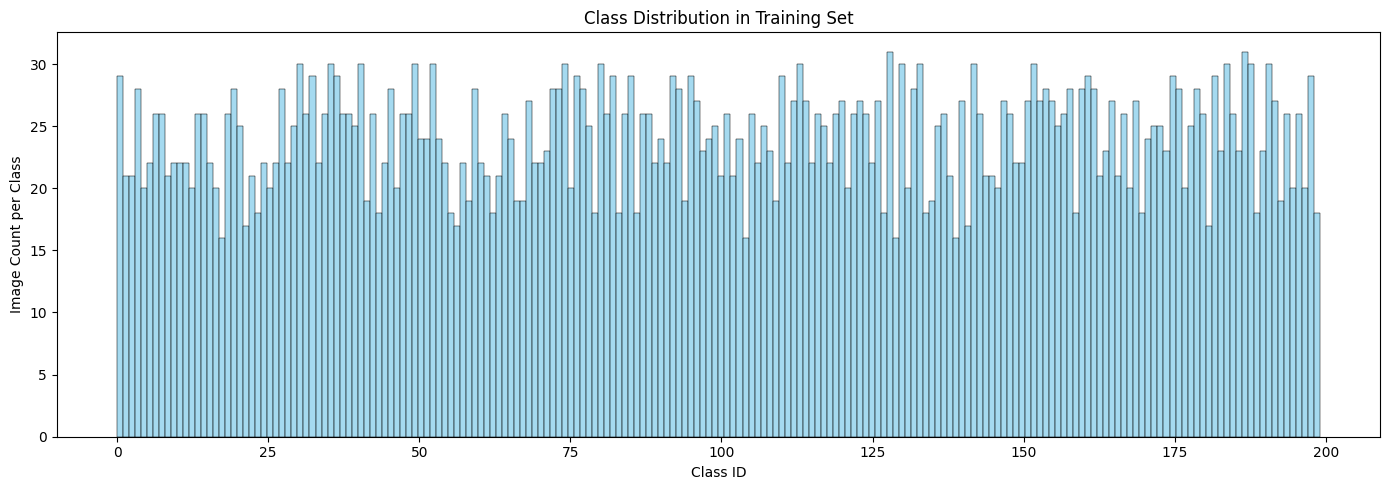


⚖️ Class Distribution Range: min=16, max=31, ratio=1.94
⚠️ Potential class imbalance detected — consider data augmentation or weighted sampling.


In [ ]:
# --- 3️⃣ Class Distribution Analysis ---

# Visualise Class Counts
# Configure plot dimensions and title for the histogram
plt.figure(figsize=(14, 5))
# Generate histogram of class IDs to visualise distribution in the training set
sns.histplot(train_df["class_id"], bins=200, kde=False, color="skyblue")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class ID")
plt.ylabel("Image Count per Class")
plt.tight_layout()
plt.show()

# Calculate and Report Imbalance
# Calculate the count for each class
class_counts = train_df["class_id"].value_counts()
# Determine the imbalance ratio (Maximum count / Minimum count)
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n⚖️ Class Distribution Range: min={class_counts.min()}, max={class_counts.max()}, ratio={imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("⚠️ Potential class imbalance detected — consider data augmentation or weighted sampling.")
else:
    print("✅ Class distribution appears relatively balanced.")

## &emsp;&emsp;**2.3 🧼 Data Preprocessing and Augmentation**

> This subsection defines two distinct image transformation pipelines: a mild, detail-preserving augmentation pipeline for training, and a deterministic pipeline for validation/testing, both using ImageNet normalisation. This strategy aims to prevent overfitting on the fine-grained bird data by introducing variance (flip, small rotation, subtle color jitter) while avoiding excessive distortion that would destroy critical semantic details.

In [ ]:
# --- 1️⃣ Image Transformation Pipelines ---

# Standard mean and standard deviation derived from the ImageNet dataset.
# REQUIRED for utilising pre-trained weights (ResNet, EfficientNet, etc.).
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Training Transform (Naturalistic Augmentation)
# Purpose: Introduce variance while preserving subtle classification details (e.g., bird plumage).
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),        # Initial scale to ensure 224x224 crop is possible
    transforms.RandomCrop((224, 224)),    # Data augmentation technique
    transforms.RandomHorizontalFlip(p=0.5), # Standard augmentation for symmetry
    transforms.RandomRotation(degrees=15),  # Mild rotation (max 15 deg) to avoid disorienting structure
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15   # Conservative color shifts to protect subtle details
    ),
    transforms.ToTensor(),                  # Convert image to PyTorch tensor format
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), # Apply ImageNet normalisation
])

# Validation / Test Transform (Deterministic)
# Purpose: Ensure consistent, non-augmented input for evaluation metrics.
# Disclaimer: Will be using test set as validation due to limited data; excluded from training.
val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),    # Scale up for consistent sampling
    transforms.CenterCrop((224, 224)), # Crop to the final expected input size
    transforms.ToTensor(),            # Convert image to PyTorch tensor format
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std), # Apply ImageNet normalization
])

print("\nTransform Pipelines Ready:")
print(train_transform)
print(val_test_transform)
print("\n✅ Data Augmentation configured carefully to balance realism and generalisation.")


Transform Pipelines Ready:
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

✅ Data Augmentation configured carefully to balance realism and generalisation.


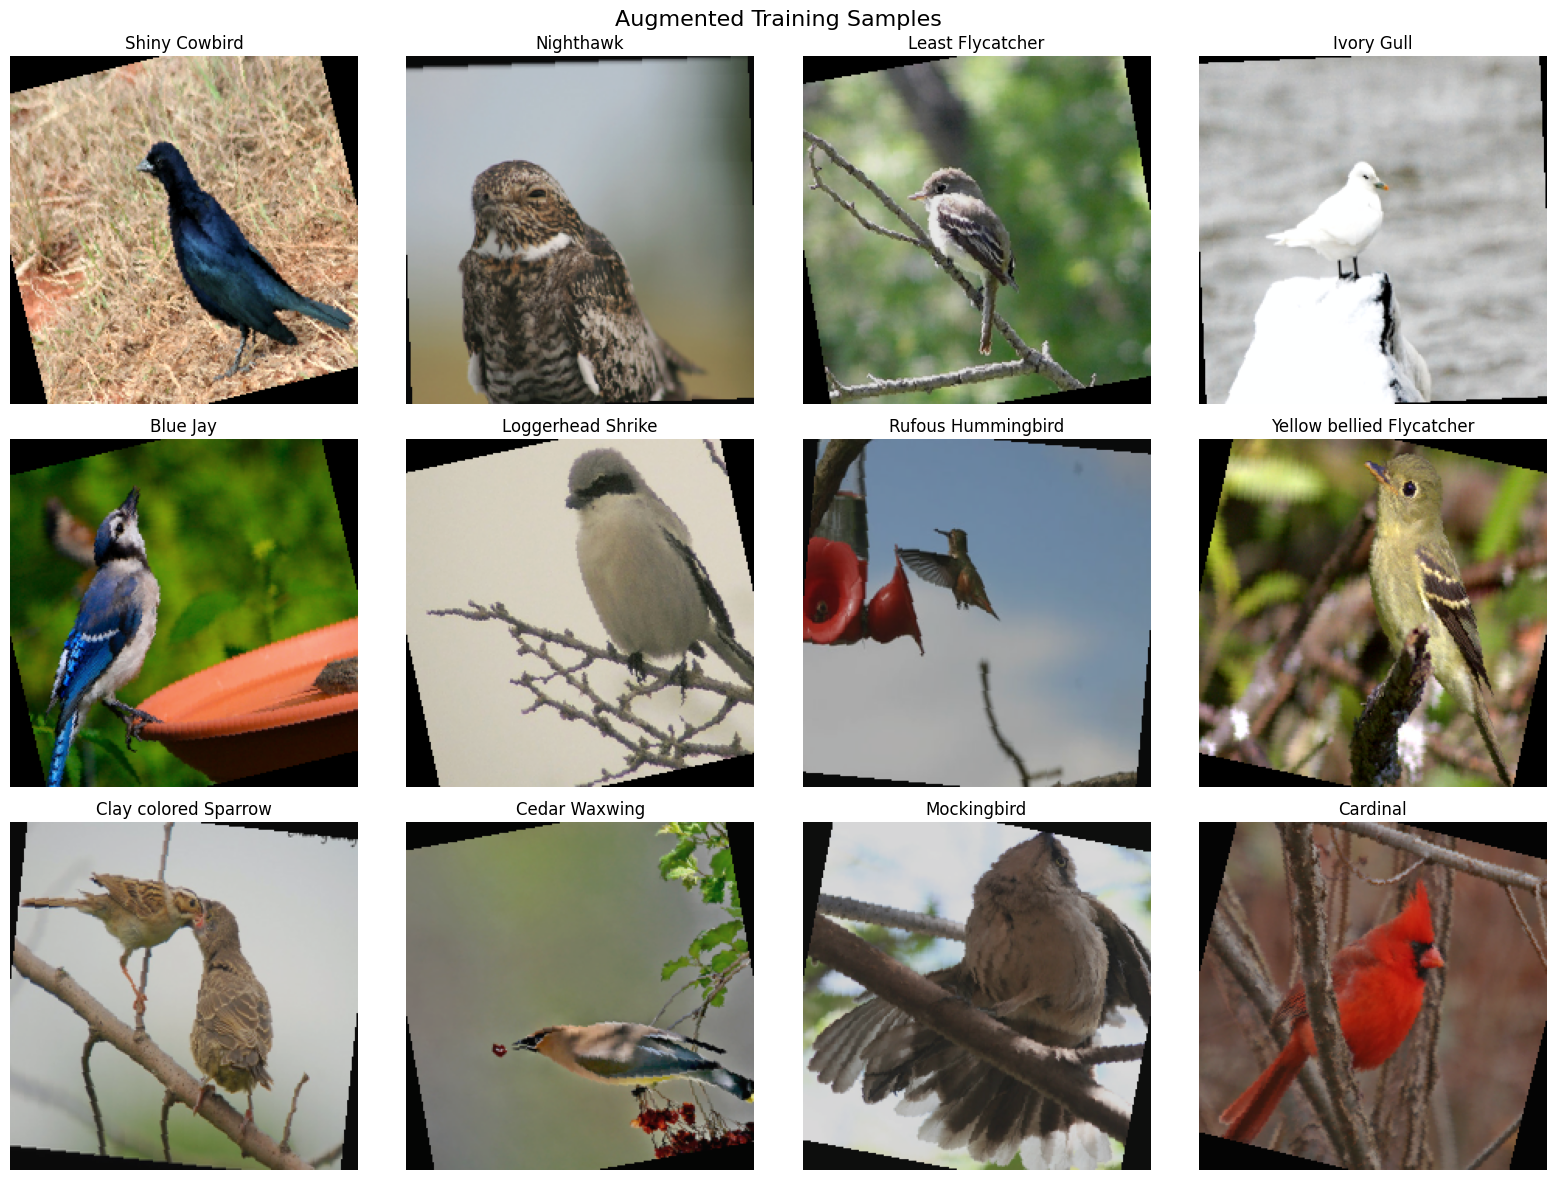

In [ ]:
# --- 2️⃣ Augmentation Visualisation and Verification ---

# Visualisation Function
def visualise_augmentations(df, dataset_dir, transform, n=12):
    """
    Visualises the effects of the defined training transforms on sample images.
    This function ensures the augmentation pipeline introduces necessary variance
    without destroying the fine-grained visual details required for classification.
    """
    # Setup subplot figure (e.g., 3 rows, 4 columns for n=12)
    fig, axes = plt.subplots(3, n//3, figsize=(16, 12))
    # Sample N rows from the training DataFrame for display
    sample_df = df.sample(n, random_state=42).reset_index(drop=True)

    # Iterate through the sampled images and subplots
    for ax, (_, row) in zip(axes.flatten(), sample_df.iterrows()):
        img_path = os.path.join(dataset_dir, row["image_path"])
        try:
            img = Image.open(img_path).convert("RGB") # Load image via PIL
            aug_img = transform(img) # Apply the full training transform pipeline

            #  Denormalisation for Display
            aug_img = aug_img.permute(1, 2, 0).numpy() # Reorder dimensions (C, H, W) -> (H, W, C)
            # Denormalise using ImageNet stats
            aug_img = aug_img * np.array(imagenet_std) + np.array(imagenet_mean)
            aug_img = np.clip(aug_img, 0, 1) # Clip values to [0, 1] for correct display

            ax.imshow(aug_img)
            ax.set_title(row["class_name"], fontsize=12)
            ax.axis("off") # Hide axes
        except:
            # Handle cases where image file might be missing or corrupt
            ax.text(0.5, 0.5, "Missing", ha="center", va="center")
            ax.axis("off")

    plt.suptitle("Augmented Training Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Execute the visualisation function using the training data and transforms
visualise_augmentations(train_df, train_dir, train_transform)

## &emsp;&emsp;**2.4 🚚 PyTorch Dataset and DataLoaders**


> This final subsection implements the CUB200Dataset custom class to handle image loading and transformation, then instantiates the training and validation datasets (using test data for validation) and wraps them in PyTorch DataLoaders to efficiently feed batches of images and labels to the model.

In [ ]:
# --- 1️⃣ PyTorch Dataset and DataLoaders ---

# Custom Dataset Class
class CUB200Dataset(Dataset):
    """
    Custom PyTorch Dataset for the CUB-200 Birds dataset.
    Responsible for loading, transforming, and serving image-label pairs.
    """
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): Contains image filenames and integer class labels.
            root_dir (str): Path to the dataset root directory (Train or Test folder).
            transform (callable, optional): Image transformation pipeline (e.g., augmentation).
        """
        self.data = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        """Return total number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """Load one image and return (image_tensor, label)."""
        row = self.data.iloc[idx]
        img_path = os.path.join(self.root_dir, row["image_path"])
        # Ensure label is a standard integer type
        label = int(row["class_id"])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Failed to load image: {img_path} ({e}). Returning blank image.")
            # Fail-safe: return a black tensor if the file is missing
            image = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label

# Dataset Assignment (Using Test as Validation)
# Due to the small training dataset, the full 'train_df' is used for training.
# The original 'test_df' is repurposed as the validation set (val_dataset) for
# monitoring performance and determining early stopping.

# Training set uses the full training data and data augmentation (train_transform)
train_dataset = CUB200Dataset(train_df, train_dir, transform=train_transform)
# Validation set uses the test data with deterministic transform (val_test_transform)
val_dataset = CUB200Dataset(test_df, test_dir, transform=val_test_transform)

print(f"\nDataset Assignment: {len(train_dataset)} images (Train) | {len(val_dataset)} images (Validation/Test)")

# DataLoader Parameters
BATCH_SIZE = 32
# Adjust workers based on hardware availability
NUM_WORKERS = 4 if torch.cuda.is_available() else 2

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True) # Shuffle for training
# Validation set is used for per-epoch monitoring and early stopping
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)  # No shuffle, deterministic transforms

# Verification Step
# Pull one batch from the training loader to confirm tensor shapes
sample_batch = next(iter(train_loader))
images, labels = sample_batch

print("\n🚀 DataLoader Verification:")
print(f"Batch Image Tensor Shape: {images.shape} (Batch x Channel x Height x Width)")
print(f"Batch Label Tensor Shape: {labels.shape}")
print(f"Number of Classes (Total): {train_df['class_id'].nunique()}")
print(f"Example Labels (First 10): {labels[:10].tolist()}")
print("\n✅ Dataset and DataLoaders are ready for model training!")


Dataset Assignment: 4829 images (Train) | 1204 images (Validation/Test)

🚀 DataLoader Verification:
Batch Image Tensor Shape: torch.Size([32, 3, 224, 224]) (Batch x Channel x Height x Width)
Batch Label Tensor Shape: torch.Size([32])
Number of Classes (Total): 200
Example Labels (First 10): [84, 176, 120, 151, 25, 172, 38, 20, 189, 44]

✅ Dataset and DataLoaders are ready for model training!


# **3.0 🧩 Utility Functions**

> This primary subsection defines core functions for model training, validation, and metric computation, including per-epoch updates, performance evaluation, and result tracking.

In [ ]:
# --- 1️⃣ Training & Validation Utilities ---

# Training Function
def train_one_epoch(model, dataloader, criterion, optimiser, device):
    """
    Executes one full training epoch with backpropagation and weight updates.
    Returns: epoch_loss (float), epoch_acc (float)
    """
    # Set to training mode (enables dropout, Batch Normalisation updates).
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Initialise progress bar for visual feedback.
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in progress_bar:
        # Move data to the specified device (GPU/CPU).
        images, labels = images.to(device), labels.to(device)

        optimiser.zero_grad() # Zero gradients.
        outputs = model(images)  # Forward pass.
        loss = criterion(outputs, labels)  # Calculate batch loss.

        loss.backward()  # Backward pass: compute gradients.
        optimiser.step()  # Update model parameters.

        running_loss += loss.item() * images.size(0)  # Accumulate weighted loss.

        # Calculate predictions and batch accuracy.
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}") # Display current batch loss in tqdm.

    # Calculate overall epoch metrics (Top-1 Accuracy).
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Validation Function
def validate(model, dataloader, criterion, device, num_classes=200):
    """
    Evaluates model performance on the validation set, calculating Top-1 and
    Average Per-Class Accuracy.
    Returns: epoch_loss (float), epoch_acc (float), avg_per_class_acc (float)
    """
    # Set to evaluation mode (disables dropout, fixes Batch Normalisation stats).
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    # Initialise arrays to track per-class correct/total counts.
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    with torch.no_grad(): # Disable gradient computation for efficiency.
        for images, labels in tqdm(dataloader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1) # Compute overall Top-1 accuracy.
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Update per-class metrics.
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (preds[i] == labels[i]).item()
                class_total[label] += 1

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    # Calculate Average Per-Class Accuracy (Clip class_total to prevent division by zero).
    avg_per_class_acc = np.mean(class_correct / np.clip(class_total, 1, None))
    return epoch_loss, epoch_acc, avg_per_class_acc

In [ ]:
# --- 2️⃣ History & Visualisation Utililies ---

def init_history():
    """
    Initialises an empty dictionary for tracking training and validation metrics.
    """
    return {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_per_class_acc": []
    }

def plot_history(history, save_path=None, filename="training_history.png"):
    """
    Plots training and validation loss/accuracy curves over epochs.
    Args:
        history (dict): Dictionary containing lists for 'train_loss', 'val_loss', etc.
        save_path (str, optional): Directory path to save the plot image.
    """
    epochs = range(1, len(history["train_loss"]) + 1) # Define x-axis values.

    plt.figure(figsize=(14, 5))

    # --- Loss Curve ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # --- Accuracy Curve ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust subplots to fit figure area.

    # Save figure if a path is provided
    if save_path:
        save_file = os.path.join(save_path, filename)
        plt.savefig(save_file)
        print(f"📊 Saved training history plot to {save_file}")

    plt.show() # Display the plot

# Save History Function
def save_training_history(history, save_dir="checkpoints", filename="training_history.json"):
    """
    Persists the training and validation metrics history as a JSON file.
    """
    os.makedirs(save_dir, exist_ok=True)
    history_path = os.path.join(save_dir, filename)
    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)
    print(f"✅ Training history saved to: {history_path}")

# **4.0 🐣 Model 1: Baseline CNN (From Scratch)**

> This section presents the development, training, and evaluation of a custom BaselineCNN model to establish a performance benchmark, demonstrating through its limited accuracy and overfitting behaviour the necessity of adopting a more advanced, pretrained architecture for fine-grained classification.

## &emsp;&emsp;**4.1 Architecture and Strategy**

> Training a smaller BaselineCNN without transfer learning first serves as a sanity check and establishes a minimum performance threshold (the goal), with the hope of finding that a simple architecture struggles with the fine-grained classification task, thus justifying the necessity of a complex, pretrained model (like a fine-tuned ResNet or EfficientNet). This section therefore defines and initialises the custom BaselineCNN architecture (with 1.1M parameters), demonstrating its structure and confirming its correct output shape for the 200 classes.

In [ ]:
# --- 1️⃣ Baseline CNN Model Architecture ---

# Global parameters for all models
NUM_CLASSES = 200   # CUB-200 requires 200 classes
DROPOUT_PROB = 0.5

class BaselineCNN(nn.Module):
    """
    A custom CNN model suitable as a baseline classifier.
    Architecture: Four Conv blocks (Conv-BN-ReLU-MaxPool) leading to
    an AdaptiveAvgPool, followed by a simple FC classification head with Dropout.
    Input size is assumed to be 224x224.
    """
    def __init__(self, num_classes=NUM_CLASSES, dropout_prob=DROPOUT_PROB):
        super().__init__()

        # Convolutional backbone (VGG-like blocks)
        self.features = nn.Sequential(
            # Block 1: 3 -> 32. Reduces HxW to 112x112.
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 32 -> 64. Reduces HxW to 56x56.
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 64 -> 128. Reduces HxW to 28x28.
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 128 -> 256. Reduces HxW to 14x14.
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Final Conv layer before pooling (14x14 feature map)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Global pooling + Classification head
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output size [B, 256, 1, 1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_prob),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256), # Using BatchNorm1d after the ReLU layer for better training stability
            nn.Dropout(p=dropout_prob * 0.5), # Reduced dropout in the second layer
            nn.Linear(256, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        """
        Initialises weights using Kaiming Normal (He) for Conv layers and
        Normal distribution for Linear layers. aBatchNorm is set to defult (ones/zeros).
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        """Standard forward pass."""
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

In [ ]:
# --- 2️⃣ Instantiate and Summarise ---
def count_parameters(model):
    """Counts the number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineCNN(num_classes=NUM_CLASSES, dropout_prob=DROPOUT_PROB).to(device)

print("=== BaselineCNN Summary ===")
print(f"Device: {device}")
print(f"Number of trainable parameters: {count_parameters(model):,}")

# Try to print torchsummary if available; otherwise, show a basic layer print and a dummy forward.
try:
    # Requires: from torchsummary import summary
    # Typical input for our pipeline: 3x224x224
    summary(model, input_size=(3, 224, 224), device=str(device))
except NameError:
    # Handle the case where 'summary' (from torchsummary) is not imported or installed.
    print("\n[INFO] 'torchsummary.summary' not available; performing manual check:")
    print(model)
    # Perform a dummy forward pass to verify input/output shapes.
    with torch.no_grad():
        dummy = torch.randn(2, 3, 224, 224).to(device)
        out = model(dummy)
    print(f"Dummy forward output shape (batch=2): {out.shape}")
except Exception as e:
    # Catch other exceptions like 'device' mismatch in summary.
    print(f"\n[INFO] torchsummary failed with error: {e}. Printing model architecture and doing dummy forward.")
    print(model)
    with torch.no_grad():
        dummy = torch.randn(2, 3, 224, 224).to(device)
        out = model(dummy)
    print(f"Dummy forward output shape (batch=2): {out.shape}")

=== BaselineCNN Summary ===
Device: cpu
Number of trainable parameters: 1,096,936
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,432
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,728
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13 

## &emsp;&emsp;**4.2 Model Training**

> This subsection establishes the training protocol for the BaselineCNN using the AdamW optimiser, CrossEntropyLoss, and a learning rate scheduler, saving the model based on the best validation loss. Training was permitted to run for 80 epochs (or until early stopping), and the subsequent finding is that the baseline model achieved a sub-optimal validation accuracy of ~42% and demonstrably overfit the training data (where its training accuracy was beginning to be much higher) before the set limit, confirming the need for a more powerful transfer learning approach on this fine-grained dataset.

In [ ]:
# --- 1️⃣ Hyperparameters ---
EPOCHS = 80 # Total number of training passes over the full dataset.
BATCH_SIZE = 32 # Number of samples processed before the model's parameters are updated.
LEARNING_RATE = 1e-3 # Step size used for updating model weights during training.
WEIGHT_DECAY = 1e-4 # L2 regularisation term to help prevent overfitting.
EARLY_STOPPING_PATIENCE = 5 # Number of epochs to wait for improvement before stopping.

In [ ]:
# --- 2️⃣ Setup ---
criterion = nn.CrossEntropyLoss() # Loss Function: CrossEntropyLoss is standard for multi-class classification.
# Optimiser: AdamW is a modern choice, often outperforming standard Adam.
optimiser = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Learning Rate Scheduler: Reduces LR when validation loss plateaus, improving convergence
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=3)

# Initialisation for Tracking
best_val_loss = float('inf') # Stores the best achieved validation loss to save the best model.
epochs_no_improve = 0 # Counter for early stopping logic.
# Dictionary to store metrics for plotting the training history later.
history = init_history()

# Checkpoint Setup
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True) # Create directory to save model weights.
model_path = os.path.join(save_dir, "baseline_cnn.pth") # File path for saving the best model.

In [ ]:
# --- 3️⃣ Training Loop ---
print("\n🚀 Starting BaselineCNN training...\n")
for epoch in range(1, EPOCHS + 1):
    print(f"\n🌀 Epoch {epoch}/{EPOCHS}")
    # Run a full training pass and get metrics
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimiser, device)
    # Run a full validation pass (Crucial for assessing generalisation)
    val_loss, val_acc, val_per_class_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss) # Step the learning rate scheduler based on validation loss

    # Log metrics to the history dictionary for later plotting
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['val_per_class_acc'].append(val_per_class_acc)

    print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"🧪 Val Loss:    {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%, (Avg. Per Class): {val_per_class_acc*100:.2f}%")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss # Save the model only if validation performance improved
        epochs_no_improve = 0
        torch.save(model.state_dict(), model_path)
        print(f"💾 Saved new best model → {model_path}")
    else: # Increment counter and check if early stopping patience is exceeded
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"⏹️ Early stopping triggered at epoch {epoch}.")
            break

print("\n✅ Training complete.")
print(f"Best validation loss: {best_val_loss:.4f}")


🚀 Starting BaselineCNN training...


🌀 Epoch 1/25


Training:   0%|          | 0/151 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📉 Train Loss: 5.1821 | Train Acc: 1.33%
🧪 Val Loss:    5.0875 | Val Acc: 1.33%, (Avg. Per Class): 1.23%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 2/25


📉 Train Loss: 4.9939 | Train Acc: 2.63%
🧪 Val Loss:    4.9664 | Val Acc: 2.08%, (Avg. Per Class): 1.86%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 3/25


📉 Train Loss: 4.8456 | Train Acc: 3.29%
🧪 Val Loss:    4.8121 | Val Acc: 3.41%, (Avg. Per Class): 3.24%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 4/25


📉 Train Loss: 4.7322 | Train Acc: 3.67%
🧪 Val Loss:    4.7412 | Val Acc: 5.40%, (Avg. Per Class): 5.16%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 5/25


📉 Train Loss: 4.6546 | Train Acc: 4.14%
🧪 Val Loss:    4.7218 | Val Acc: 5.40%, (Avg. Per Class): 5.03%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 6/25


📉 Train Loss: 4.5657 | Train Acc: 5.01%
🧪 Val Loss:    4.5747 | Val Acc: 6.15%, (Avg. Per Class): 5.81%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 7/25


📉 Train Loss: 4.4764 | Train Acc: 5.34%
🧪 Val Loss:    4.5534 | Val Acc: 6.06%, (Avg. Per Class): 5.73%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 8/25


📉 Train Loss: 4.4051 | Train Acc: 5.45%
🧪 Val Loss:    4.3787 | Val Acc: 8.06%, (Avg. Per Class): 7.81%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 9/25


📉 Train Loss: 4.3488 | Train Acc: 6.92%
🧪 Val Loss:    4.4466 | Val Acc: 7.48%, (Avg. Per Class): 7.06%

🌀 Epoch 10/25


📉 Train Loss: 4.2548 | Train Acc: 7.37%
🧪 Val Loss:    4.3454 | Val Acc: 6.81%, (Avg. Per Class): 6.42%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 11/25


📉 Train Loss: 4.2125 | Train Acc: 8.16%
🧪 Val Loss:    4.2472 | Val Acc: 9.88%, (Avg. Per Class): 9.56%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 12/25


📉 Train Loss: 4.1401 | Train Acc: 8.47%
🧪 Val Loss:    4.2432 | Val Acc: 10.22%, (Avg. Per Class): 9.91%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 13/25


📉 Train Loss: 4.1143 | Train Acc: 8.41%
🧪 Val Loss:    4.1614 | Val Acc: 10.63%, (Avg. Per Class): 10.20%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 14/25


📉 Train Loss: 4.0502 | Train Acc: 9.55%
🧪 Val Loss:    4.2365 | Val Acc: 8.55%, (Avg. Per Class): 8.30%

🌀 Epoch 15/25


📉 Train Loss: 3.9852 | Train Acc: 9.67%
🧪 Val Loss:    4.0934 | Val Acc: 10.38%, (Avg. Per Class): 9.84%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 16/25


📉 Train Loss: 3.9613 | Train Acc: 10.19%
🧪 Val Loss:    4.0348 | Val Acc: 11.88%, (Avg. Per Class): 11.49%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 17/25


📉 Train Loss: 3.8913 | Train Acc: 11.58%
🧪 Val Loss:    3.9873 | Val Acc: 12.21%, (Avg. Per Class): 11.44%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 18/25


📉 Train Loss: 3.8347 | Train Acc: 11.85%
🧪 Val Loss:    3.9376 | Val Acc: 12.96%, (Avg. Per Class): 12.31%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 19/25


📉 Train Loss: 3.7849 | Train Acc: 12.47%
🧪 Val Loss:    3.8766 | Val Acc: 14.04%, (Avg. Per Class): 13.78%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 20/25


📉 Train Loss: 3.7416 | Train Acc: 13.61%
🧪 Val Loss:    3.8861 | Val Acc: 14.78%, (Avg. Per Class): 14.26%

🌀 Epoch 21/25


📉 Train Loss: 3.7077 | Train Acc: 13.54%
🧪 Val Loss:    3.8185 | Val Acc: 13.79%, (Avg. Per Class): 13.47%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

🌀 Epoch 22/25


📉 Train Loss: 3.6573 | Train Acc: 14.14%
🧪 Val Loss:    3.8819 | Val Acc: 14.53%, (Avg. Per Class): 14.21%

🌀 Epoch 23/25


📉 Train Loss: 3.6102 | Train Acc: 15.32%
🧪 Val Loss:    3.8567 | Val Acc: 14.53%, (Avg. Per Class): 14.09%

🌀 Epoch 24/25


📉 Train Loss: 3.5793 | Train Acc: 15.59%
🧪 Val Loss:    3.8650 | Val Acc: 14.29%, (Avg. Per Class): 13.80%

🌀 Epoch 25/25


📉 Train Loss: 3.5200 | Train Acc: 16.82%
🧪 Val Loss:    3.6799 | Val Acc: 17.52%, (Avg. Per Class): 17.12%
💾 Saved new best model → ./checkpoints/baseline_cnn_best.pth

✅ Training complete.
Best validation loss: 3.6799


In [ ]:
# --- 4️⃣ Save History ---
# Save History using the remembered utility function
save_training_history(history, save_dir=save_dir)
print(f"🧾 Training history saved → {save_dir}/training_history.json")

🧾 Training history saved → ./checkpoints/training_history.json


## &emsp;&emsp;**4.3 Result Analysis**

> This final subsection showcases the recorded performance metrics to generate the historical loss and accuracy plots that visualise the final overfitting conclusion.

📊 Saved training history plot to ./checkpoints/training_history.png


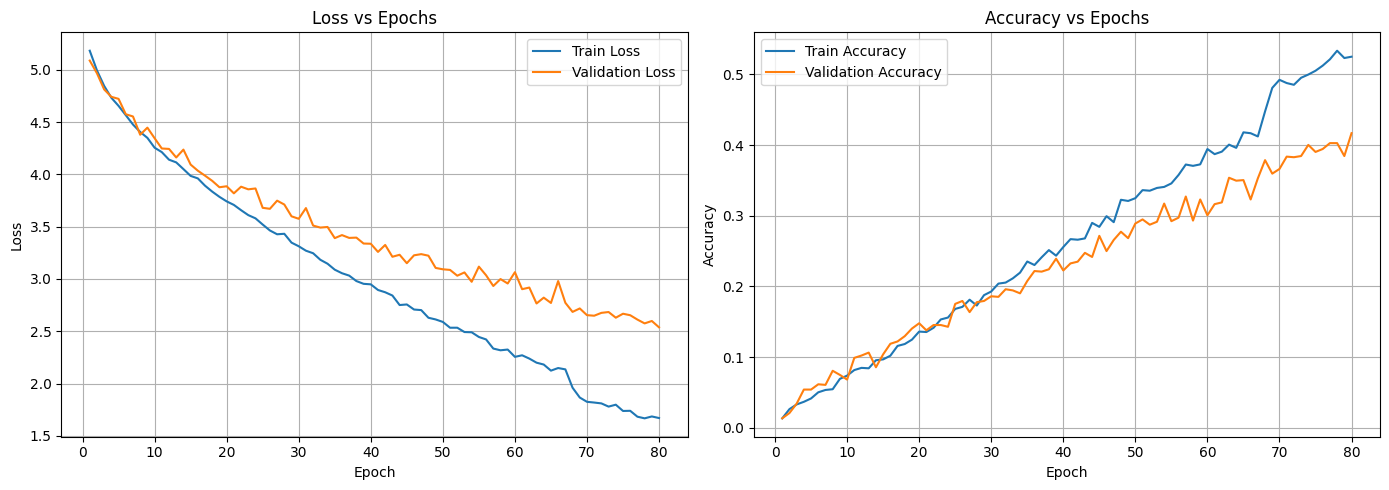

In [ ]:
# Plot History using the utility function
plot_history(history, save_path=save_dir)

> The initial experiment using the custom BaselineCNN, trained from scratch, successfully established a minimum performance benchmark for the CUB-200 fine-grained classification task. While the model showed rapid initial learning and confirmed the architectural setup was functional, its generalisation capacity was quickly limited by the small dataset size (only ~20 images per class). Training progressed until clear signs of overfitting emerged around epoch 50, resulting in an significant performance gap where training accuracy reached $\approx 53\%$ but validation accuracy stalled and plateaued at a moderate $\approx 42\%$. This empirical finding decisively demonstrates that a network trained without prior knowledge lacks the complexity and pre-learned features required for subtle visual distinction on limited data, thus fully justifying the necessity of transitioning to a transfer learning approach utilising a deep, pretrained backbone (such as ResNet or EfficientNet) to overcome data scarcity and achieve superior generalisation performance.

# **5.0 🦉 Model 2: Transfer Learning (ResNet50)**

> This section applies transfer learning with a pretrained ResNet50 to enhance fine-grained bird classification. By first training the classifier head and then fine-tuning upper convolutional layers, the model achieves substantial accuracy gains over the baseline CNN. However, persistent overfitting highlights the need for more efficient architectures and stronger regularisation, motivating the transition to EfficientNetV2.

## &emsp;&emsp;**5.1 Architecture and Strategy**

> This section defines and initialises a transfer learning pipeline using ResNet50 pretrained on ImageNet. The model's convolutional backbone is frozen by default to preserve generic visual features, while a custom classifier head (with dropout regularisation and batch normalisation) is added to adapt the network for the 200 target classes. Utility functions are also included to count trainable parameters, selectively unfreeze layers for fine-tuning, and validate the model structure via summary or dummy forward pass. This setup establishes a strong, modular foundation for the subsequent fine-tuning and performance optimisation phases.

In [ ]:
# --- 1️⃣ Load pretrained ResNet50 ---
NUM_CLASSES = 200
DROPOUT_PROB = 0.5

try:
    # Attempt to use modern weights argument (V2 preferred), fallback to deprecated pretrained=True
    try:
        from torchvision.models import resnet50, ResNet50_Weights
        base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    except Exception:
        from torchvision.models import resnet50
        # Fallback for older torchvision versions
        base_model = resnet50(pretrained=True)
    print("\n✅ Loaded ResNet50 pretrained on ImageNet.")
except Exception as e:
    print(f"⚠️ Failed to load pretrained ResNet50. Error: {e}")
    # Create a non-pretrained model as a safe fallback
    base_model = resnet50(weights=None)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]



✅ Loaded ResNet50 pretrained on ImageNet.


In [ ]:
# --- 2️⃣ Freeze the backbone (all conv layers) by default ---
def set_parameter_requires_grad(model, requires_grad=False):
    """Helper function to set requires_grad for all parameters in a model."""
    for param in model.parameters():
        param.requires_grad = requires_grad

set_parameter_requires_grad(base_model, requires_grad=False)
print("🔒 Backbone parameters frozen by default.")

# --- 3️⃣ Replace the classifier head ---
# ResNet50's classifier is `model.fc` which maps 2048 -> 1000 (ImageNet)
in_features = base_model.fc.in_features  # usually 2048

# Replace the final layer with a custom classification head
base_model.fc = nn.Sequential(
    nn.Dropout(p=DROPOUT_PROB),
    nn.Linear(in_features, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),
    nn.Dropout(p=DROPOUT_PROB * 0.5), # Reduced dropout for the second layer
    nn.Linear(512, NUM_CLASSES)
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet50 = base_model.to(device)

🔒 Backbone parameters frozen by default.


In [ ]:
# --- 4️⃣ Utility: count params & print layer trainability ---
def count_trainable_parameters(model):
    """
    Counts the number of trainable and total parameters in a PyTorch model.
    Returns: trainable (int), total (int)
    """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

trainable, total = count_trainable_parameters(model_resnet50)
print(f"Model moved to {device}. Trainable params: {trainable:,} / {total:,} ({trainable/total:.2%})")

# Print top-level modules for quick inspection
print("\n=== Top-level model modules (ResNet50 with custom head) ===")
for name, module in model_resnet50.named_children():
    print(f"{name}: {module.__class__.__name__}")

# --- 5️⃣ Utility: unfreeze last N layers / blocks for fine-tuning ---
def unfreeze_backbone_layers(model, unfreeze_from_layer_name=None, unfreeze_n_layers=None):
    """
    Selectively unfreezes parts of the backbone for fine-tuning.
    Args:
        model (nn.Module): The ResNet model instance.
        unfreeze_from_layer_name (str, optional): Name of the first module (e.g., 'layer4')
            to start unfreezing from. All subsequent modules are also unfrozen.
        unfreeze_n_layers (int, optional): Unfreeze the last N parameter tensors (less precise).

    Returns: The number of parameters that are now trainable.
    """
    # Option A: unfreeze by module name (e.g., 'layer4')
    if unfreeze_from_layer_name:
        found = False
        # Iterate over named top-level children of the ResNet model
        for name, module in model.named_children():
            if name == unfreeze_from_layer_name:
                found = True
                for p in module.parameters():
                    p.requires_grad = True
            elif found:
                # if we already found the start module, unfreeze subsequent children as well
                for p in module.parameters():
                    p.requires_grad = True
        if not found:
            print(f"⚠️ Module name '{unfreeze_from_layer_name}' not found in model children.")
    # Option B: unfreeze last N parameter tensors
    elif unfreeze_n_layers:
        params = [p for p in model.parameters()]
        for p in params[-unfreeze_n_layers:]:
            p.requires_grad = True
    else:
        raise ValueError("Provide either unfreeze_from_layer_name or unfreeze_n_layers")

    trainable, total = count_trainable_parameters(model)
    print(f"Updated trainable params: {trainable:,} / {total:,} ({trainable/total:.2%})")
    return trainable

Model moved to cuda. Trainable params: 1,152,712 / 24,660,744 (4.67%)

=== Top-level model modules (ResNet50 with custom head) ===
conv1: Conv2d
bn1: BatchNorm2d
relu: ReLU
maxpool: MaxPool2d
layer1: Sequential
layer2: Sequential
layer3: Sequential
layer4: Sequential
avgpool: AdaptiveAvgPool2d
fc: Sequential


In [ ]:
# --- 6️⃣ Print model summary (torchsummary) or do dummy forward ---
try:
    summary(model_resnet50, input_size=(3, 224, 224), device=str(device))
except Exception:
    print("torchsummary not available; running a dummy forward to validate shapes...")
    with torch.no_grad():
        dummy = torch.randn(2, 3, 224, 224).to(device)
        out = model_resnet50(dummy)
    print("Dummy forward output shape:", out.shape)

print("\n✅ ResNet50 transfer model ready. Next: train the new head (phase 1), then optionally fine-tune.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## &emsp;&emsp;**5.2 Phase 1 - Train the Head**

> In this phase, only the newly added classifier head of ResNet50 is trained while the pretrained backbone remains frozen, resulting in rapid overfitting where training accuracy soars to around 81% but validation accuracy plateaus near 60%; this expected behaviour confirms that the head has fully exploited the frozen ImageNet features and signals the need to proceed to Phase 2 fine-tuning to adapt deeper layers to the bird-specific domain.

In [ ]:
# Ensure output directory
save_dir = "/content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "resnet50_head.pth")

# Make sure backbone is frozen (safety)
for name, param in model_resnet50.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Hyperparameters
EPOCHS = 20                   # head should converge fast
BATCH_SIZE = train_loader.batch_size
LR = 1e-3                     # basic starting LR for new head
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 5

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model_resnet50.fc.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

# Containers
history = init_history()

best_val_loss = float("inf")
epochs_no_improve = 0

In [ ]:
print(f"🚀 Starting Phase 1 Training (Head Only) for {EPOCHS} epochs...")

for epoch in range(1, EPOCHS + 1):
    print(f"\n🌀 Epoch {epoch}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model_resnet50, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_per_class_acc = validate(model_resnet50, val_loader, criterion, device)
    scheduler.step()

    # Record
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_per_class_acc"].append(val_per_class_acc)

    print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"🧪 Val Loss:   {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% (Avg/Class: {val_per_class_acc*100:.2f}%)")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model_resnet50.state_dict(), model_path)
        print(f"💾 Saved new best model → {model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"⏹️ Early stopping triggered at epoch {epoch}.")
            break

    # Save training history JSON every epoch
    save_training_history(history, save_dir, filename="training_history_head.json")

print("\n✅ Phase 1 training complete.")
print(f"Best validation loss: {best_val_loss:.4f}")

🚀 Starting Phase 1 Training (Head Only) for 20 epochs...

🌀 Epoch 1/20


📉 Train Loss: 4.2364 | Train Acc: 14.27%
🧪 Val Loss:   3.0243 | Val Acc: 32.14% (Avg/Class: 30.95%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 2/20


📉 Train Loss: 2.6652 | Train Acc: 37.32%
🧪 Val Loss:   2.3583 | Val Acc: 43.52% (Avg/Class: 43.06%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 3/20


📉 Train Loss: 2.0827 | Train Acc: 48.13%
🧪 Val Loss:   2.0666 | Val Acc: 48.26% (Avg/Class: 47.52%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 4/20


📉 Train Loss: 1.7451 | Train Acc: 54.98%
🧪 Val Loss:   1.9431 | Val Acc: 50.17% (Avg/Class: 49.70%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 5/20


📉 Train Loss: 1.5511 | Train Acc: 59.04%
🧪 Val Loss:   1.8450 | Val Acc: 51.99% (Avg/Class: 51.34%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 6/20


📉 Train Loss: 1.3948 | Train Acc: 61.61%
🧪 Val Loss:   1.8289 | Val Acc: 53.07% (Avg/Class: 52.50%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 7/20


📉 Train Loss: 1.2727 | Train Acc: 65.17%
🧪 Val Loss:   1.8199 | Val Acc: 51.91% (Avg/Class: 51.49%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 8/20


📉 Train Loss: 1.1514 | Train Acc: 68.36%
🧪 Val Loss:   1.7624 | Val Acc: 55.07% (Avg/Class: 54.61%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 9/20


📉 Train Loss: 1.0739 | Train Acc: 69.46%
🧪 Val Loss:   1.7225 | Val Acc: 54.15% (Avg/Class: 53.58%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 10/20


📉 Train Loss: 1.0112 | Train Acc: 71.42%
🧪 Val Loss:   1.6649 | Val Acc: 56.73% (Avg/Class: 56.05%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 11/20


📉 Train Loss: 0.9264 | Train Acc: 74.57%
🧪 Val Loss:   1.6892 | Val Acc: 57.14% (Avg/Class: 56.53%)

🌀 Epoch 12/20


📉 Train Loss: 0.8908 | Train Acc: 74.94%
🧪 Val Loss:   1.6633 | Val Acc: 57.89% (Avg/Class: 57.46%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 13/20


📉 Train Loss: 0.8192 | Train Acc: 76.66%
🧪 Val Loss:   1.6363 | Val Acc: 59.63% (Avg/Class: 59.17%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 14/20


📉 Train Loss: 0.8119 | Train Acc: 77.39%
🧪 Val Loss:   1.6136 | Val Acc: 59.55% (Avg/Class: 58.98%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 15/20


📉 Train Loss: 0.7712 | Train Acc: 78.21%
🧪 Val Loss:   1.6186 | Val Acc: 59.05% (Avg/Class: 58.61%)

🌀 Epoch 16/20


📉 Train Loss: 0.7271 | Train Acc: 79.46%
🧪 Val Loss:   1.5892 | Val Acc: 59.39% (Avg/Class: 58.82%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 17/20


📉 Train Loss: 0.7309 | Train Acc: 80.04%
🧪 Val Loss:   1.5792 | Val Acc: 59.39% (Avg/Class: 58.77%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth

🌀 Epoch 18/20


📉 Train Loss: 0.6977 | Train Acc: 80.91%
🧪 Val Loss:   1.5863 | Val Acc: 59.97% (Avg/Class: 59.37%)

🌀 Epoch 19/20


📉 Train Loss: 0.7045 | Train Acc: 80.12%
🧪 Val Loss:   1.5934 | Val Acc: 59.97% (Avg/Class: 59.27%)

🌀 Epoch 20/20


📉 Train Loss: 0.6731 | Train Acc: 81.26%
🧪 Val Loss:   1.5890 | Val Acc: 60.22% (Avg/Class: 59.68%)

✅ Phase 1 training complete.
Best validation loss: 1.5792


📊 Saved training history plot to ./checkpoints/training_history.png


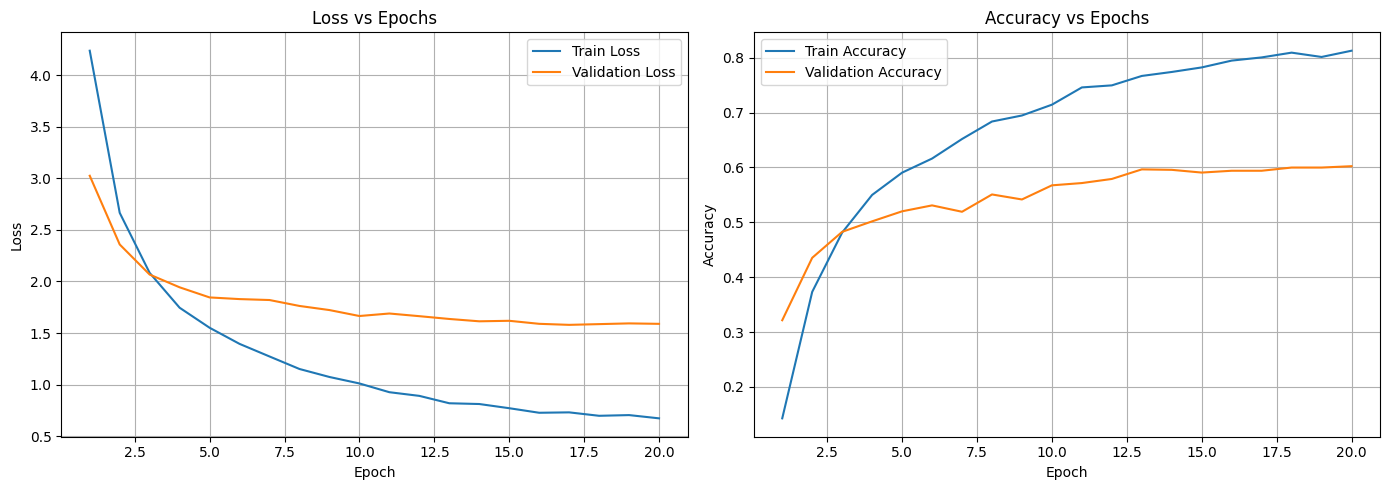

In [ ]:
# Plot History using the utility function
plot_history(history, save_path=save_dir)

## &emsp;&emsp;**5.3 Phase 2 - Fine-Tuning & Analysis**

> In this phase, the upper convolutional layers (layer4) and classifier head of ResNet50 are unfrozen and jointly optimised with differential learning rates, enabling selective adaptation of high-level ImageNet features to bird-specific visual patterns. This fine-tuning step effectively bridges the representational gap left by the frozen backbone, improving validation performance but likewise struggled with the overfitting issue.

In [ ]:
# Load the best head-trained model first
finetune_model_path = os.path.join(save_dir, "resnet50_finetune_best.pth")
checkpoint_path = os.path.join(save_dir, "resnet50_head_best.pth") # Load best Phase 1 model
model_resnet50.load_state_dict(torch.load(checkpoint_path, map_location=device))
print(f"✅ Loaded pretrained head weights from {checkpoint_path}")

# Unfreeze top convolutional block + classifier head
unfreeze_backbone_layers(model_resnet50, unfreeze_from_layer_name="layer4")

# Differential learning rates
backbone_params = [p for n, p in model_resnet50.named_parameters() if "layer4" in n and p.requires_grad]
head_params = [p for n, p in model_resnet50.named_parameters() if "fc" in n and p.requires_grad]

# Hyperparameters
EPOCHS = 30
LR_BACKBONE = 1e-5
LR_HEAD = 5e-5
WEIGHT_DECAY = 1e-4
EARLY_STOPPING_PATIENCE = 7

criterion = nn.CrossEntropyLoss()
optimizer = AdamW([
    {"params": backbone_params, "lr": LR_BACKBONE},
    {"params": head_params, "lr": LR_HEAD}
], weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Containers
history = init_history()
best_val_loss = float("inf")
epochs_no_improve = 0

✅ Loaded pretrained head weights from /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_head_best.pth


In [ ]:
print(f"🚀 Starting Phase 2 Fine-Tuning for {EPOCHS} epochs...")

for epoch in range(1, EPOCHS + 1):
    print(f"\n🌀 Epoch {epoch}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model_resnet50, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_per_class_acc = validate(model_resnet50, val_loader, criterion, device)
    scheduler.step()

    # Record
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_per_class_acc"].append(val_per_class_acc)

    print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"🧪 Val Loss:   {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% (Avg/Class: {val_per_class_acc*100:.2f}%)")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model_resnet50.state_dict(), finetune_model_path)
        print(f"💾 Saved new best model → {finetune_model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"⏹️ Early stopping triggered at epoch {epoch}.")
            break

    # Save training history JSON every epoch
    save_training_history(history, save_dir, filename="training_history_finetune.json")

print("\n✅ Fine-tuning complete.")
print(f"Best validation loss: {best_val_loss:.4f}")

🚀 Starting Phase 2 Fine-Tuning for 30 epochs...

🌀 Epoch 1/30


📉 Train Loss: 0.6804 | Train Acc: 80.91%
🧪 Val Loss:   1.5112 | Val Acc: 62.29% (Avg/Class: 61.49%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 2/30


📉 Train Loss: 0.6070 | Train Acc: 82.69%
🧪 Val Loss:   1.4036 | Val Acc: 63.46% (Avg/Class: 62.72%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 3/30


📉 Train Loss: 0.5558 | Train Acc: 84.88%
🧪 Val Loss:   1.3885 | Val Acc: 64.04% (Avg/Class: 63.22%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 4/30


📉 Train Loss: 0.5153 | Train Acc: 86.04%
🧪 Val Loss:   1.3403 | Val Acc: 64.62% (Avg/Class: 63.76%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 5/30


📉 Train Loss: 0.5078 | Train Acc: 86.42%
🧪 Val Loss:   1.3316 | Val Acc: 65.20% (Avg/Class: 64.33%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 6/30


📉 Train Loss: 0.4907 | Train Acc: 86.35%
🧪 Val Loss:   1.3111 | Val Acc: 65.70% (Avg/Class: 64.86%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 7/30


📉 Train Loss: 0.4816 | Train Acc: 86.81%
🧪 Val Loss:   1.2853 | Val Acc: 65.78% (Avg/Class: 64.89%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 8/30


📉 Train Loss: 0.4451 | Train Acc: 87.37%
🧪 Val Loss:   1.2833 | Val Acc: 66.45% (Avg/Class: 65.57%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 9/30


📉 Train Loss: 0.4173 | Train Acc: 88.90%
🧪 Val Loss:   1.2489 | Val Acc: 66.78% (Avg/Class: 65.84%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 10/30


📉 Train Loss: 0.4078 | Train Acc: 88.65%
🧪 Val Loss:   1.2436 | Val Acc: 66.94% (Avg/Class: 66.23%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 11/30


📉 Train Loss: 0.4132 | Train Acc: 89.02%
🧪 Val Loss:   1.2287 | Val Acc: 67.61% (Avg/Class: 66.74%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 12/30


📉 Train Loss: 0.4015 | Train Acc: 88.98%
🧪 Val Loss:   1.2320 | Val Acc: 66.94% (Avg/Class: 66.22%)

🌀 Epoch 13/30


📉 Train Loss: 0.3909 | Train Acc: 89.48%
🧪 Val Loss:   1.2048 | Val Acc: 67.44% (Avg/Class: 66.66%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 14/30


📉 Train Loss: 0.3876 | Train Acc: 89.13%
🧪 Val Loss:   1.2009 | Val Acc: 67.69% (Avg/Class: 66.89%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 15/30


📉 Train Loss: 0.3550 | Train Acc: 90.81%
🧪 Val Loss:   1.2072 | Val Acc: 68.02% (Avg/Class: 67.29%)

🌀 Epoch 16/30


📉 Train Loss: 0.3657 | Train Acc: 90.16%
🧪 Val Loss:   1.1896 | Val Acc: 68.27% (Avg/Class: 67.61%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 17/30


📉 Train Loss: 0.3400 | Train Acc: 90.18%
🧪 Val Loss:   1.2038 | Val Acc: 67.61% (Avg/Class: 66.86%)

🌀 Epoch 18/30


📉 Train Loss: 0.3261 | Train Acc: 91.28%
🧪 Val Loss:   1.1741 | Val Acc: 67.52% (Avg/Class: 66.77%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 19/30


📉 Train Loss: 0.3403 | Train Acc: 90.89%
🧪 Val Loss:   1.1764 | Val Acc: 68.27% (Avg/Class: 67.45%)

🌀 Epoch 20/30


📉 Train Loss: 0.3312 | Train Acc: 91.14%
🧪 Val Loss:   1.1839 | Val Acc: 68.36% (Avg/Class: 67.51%)

🌀 Epoch 21/30


📉 Train Loss: 0.3306 | Train Acc: 91.34%
🧪 Val Loss:   1.1761 | Val Acc: 67.86% (Avg/Class: 66.99%)

🌀 Epoch 22/30


📉 Train Loss: 0.3252 | Train Acc: 91.36%
🧪 Val Loss:   1.1816 | Val Acc: 68.11% (Avg/Class: 67.44%)

🌀 Epoch 23/30


📉 Train Loss: 0.3249 | Train Acc: 91.36%
🧪 Val Loss:   1.1873 | Val Acc: 68.02% (Avg/Class: 67.32%)

🌀 Epoch 24/30


📉 Train Loss: 0.3193 | Train Acc: 91.90%
🧪 Val Loss:   1.1710 | Val Acc: 68.44% (Avg/Class: 67.69%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 25/30


📉 Train Loss: 0.3261 | Train Acc: 91.36%
🧪 Val Loss:   1.1592 | Val Acc: 68.27% (Avg/Class: 67.41%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/ResNet50/resnet50_finetune_best.pth

🌀 Epoch 26/30


📉 Train Loss: 0.2993 | Train Acc: 92.57%
🧪 Val Loss:   1.1697 | Val Acc: 68.60% (Avg/Class: 67.87%)

🌀 Epoch 27/30


📉 Train Loss: 0.3038 | Train Acc: 92.09%
🧪 Val Loss:   1.1597 | Val Acc: 68.27% (Avg/Class: 67.47%)

🌀 Epoch 28/30


📉 Train Loss: 0.2970 | Train Acc: 92.30%
🧪 Val Loss:   1.1677 | Val Acc: 69.19% (Avg/Class: 68.32%)

🌀 Epoch 29/30


📉 Train Loss: 0.3125 | Train Acc: 91.72%
🧪 Val Loss:   1.1786 | Val Acc: 68.11% (Avg/Class: 67.42%)

🌀 Epoch 30/30


📉 Train Loss: 0.3189 | Train Acc: 91.72%
🧪 Val Loss:   1.1687 | Val Acc: 68.77% (Avg/Class: 68.07%)

✅ Fine-tuning complete.
Best validation loss: 1.1592


📊 Saved training history plot to ./checkpoints/training_history.png


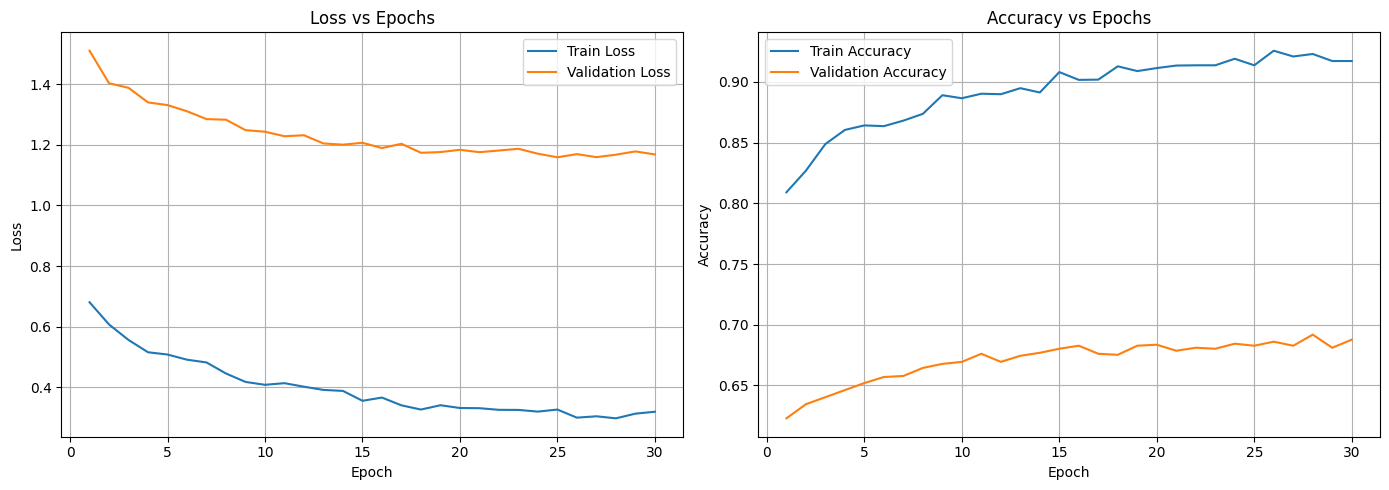

In [ ]:
# Plot History using the utility function
plot_history(history, save_path=save_dir)

> While ResNet50 fine-tuning substantially advanced performance beyond both the baseline CNN and the head-only phase, the persistent 20% train-validation gap and plateaued validation accuracy around 69% highlight the model's overfitting tendency and limited generalisation under data scarcity. To address these limitations, the next step is to explore EfficientNetV2_L, a more parameter-efficient yet high-capacity architecture that scales depth, width, and resolution in a balanced manner. By combining EfficientNetV2's adaptive compound scaling with advanced overfitting mitigation techniques, the goal is to enhance robustness and feature generalisation, hopefully finally achieving higher validation performance without excessive parameter growth or reliance on large-scale datasets.

# **6.0 🦅 Model 3: Transfer Learning (EfficientNetV2)**

> This most important section presents the development and optimisation of the main classifier of the day (EfficientNetV2-L model) using a structured two-phase transfer learning strategy supported by several advanced techniques to maximise generalisation on a limited dataset. The architecture was first adapted with a custom classifier head and validated through head-only training before gradual fine-tuning of deeper layers. Stability and robustness were reinforced through Sharpness-Aware Minimisation (SAM), Exponential Moving Average (EMA), Hybrid Loss (Label Smoothing + ArcFace), and Stochastic Weight Averaging (SWA), all optimised under differential learning rates. Performance was evaluated on the test set (used exclusively for validation and early stopping), yielding strong results with a Top-1 Accuracy of 88.12% and Average Per-Class Accuracy of 87.89%, demonstrating the model’s balanced and generalisable learning across diverse categories.

## &emsp;&emsp;**6.1 Architecture and Strategy**

> This first subsection aims to set up and prepare the EfficientNetV2-L model for transfer learning and fine-tuning. It begins by automatically selecting the available device (GPU/CPU) and loading pretrained ImageNet weights from either torchvision or timm for robustness. The classifier’s input feature size is then detected to attach a custom classification head with dropout, batch normalisation, and a configurable embedding layer suitable for tasks like ArcFace or standard softmax training. Next, freezing and unfreezing utilities are defined to control which layers are trainable, including helpers for freezing BatchNorm layers. Finally, the model is moved to the selected device, its structure and trainable parameters are summarised, and a dummy forward pass is performed to verify that all layers and shapes are correctly configured before training.

In [ ]:
# Device selection (prefer GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 1️⃣ Load pretrained EfficientNetV2-L ---
model = None
preferred_weights_note = "ImageNet pretrained weights"

try:
    # ✅ Try loading from torchvision (newer API with weight enums)
    try:
        from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
        model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
        print("✅ Loaded EfficientNetV2-L via torchvision (weights enum).")
    except Exception:
        # 🕓 Fallback for older torchvision versions using pretrained=True
        from torchvision.models import efficientnet_v2_l
        model = efficientnet_v2_l(pretrained=True)
        print("✅ Loaded EfficientNetV2-L via torchvision (pretrained=True).")
except Exception as e_tv:
    # 🔁 Final fallback: use timm if torchvision fails
    try:
        model = timm.create_model("efficientnetv2_l", pretrained=True)
        preferred_weights_note = "timm ImageNet pretrained weights"
        print("✅ Loaded EfficientNetV2-L via timm (pretrained=True).")
    except Exception as e_timm:
        # ❌ Raise error if both libraries fail
        raise RuntimeError(
            "Failed to load EfficientNetV2-L from torchvision or timm. "
            "Install/upgrade torchvision or timm."
        ) from e_timm

Device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


100%|██████████| 455M/455M [00:02<00:00, 234MB/s]


✅ Loaded EfficientNetV2-L via torchvision (weights enum).


In [ ]:
# --- 2️⃣ Utility: robustly detect classifier in_features ---

# Finds where the final Linear (classifier) layer lives and returns its input feature size.
# Works for different model structures (torchvision, timm, etc.)
def get_classifier_in_features(net):
    """
    Return the input feature size to the final Linear classifier layer.
    Searches common locations and returns the first nn.Linear.in_features found.
    """
    # candidate attributes where classifier may live
    candidate_attrs = ["classifier", "head", "fc", "pre_logits", "global_pool"]
    # Try the most common first
    for attr in candidate_attrs:
        if hasattr(net, attr):
            sub = getattr(net, attr)
            # Search inside submodules for Linear layers
            for module in sub.modules():
                if isinstance(module, nn.Linear):
                    return module.in_features
    # As a last resort, search whole network for any Linear layers and pick the last one
    last_linear = None
    for module in net.modules():
        if isinstance(module, nn.Linear):
            last_linear = module
    if last_linear is not None:
        return last_linear.in_features

    # If still not found, raise an error
    raise RuntimeError("Could not find classifier Linear layer to infer in_features.")

# --- 3️⃣ Build & attach a custom classifier head ---
NUM_CLASSES = 200
DROPOUT1 = 0.5
DROPOUT2 = 0.55
EMBED_DIM = 512  # hidden units in the new head

# Detect input size for the new head
in_feat = get_classifier_in_features(model)
print(f"Detected classifier in_features: {in_feat:,}")

class CustomEfficientNetHead(nn.Module):
    """Custom head with feature extraction + classification (supports ArcFace features)."""
    def __init__(self, in_feat, embed_dim, num_classes, dropout1, dropout2):
        super().__init__()
        # Embedding subnetwork: regularized, normalized, ReLU activated
        self.feature_extractor = nn.Sequential(
            nn.Dropout(p=dropout1),
            nn.Linear(in_feat, embed_dim, bias=True),
            nn.BatchNorm1d(embed_dim),
            nn.ReLU(inplace=True),
        )
        # Classification subnetwork
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout2),
            nn.Linear(embed_dim, num_classes, bias=True)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

    # Used when ArcFace or other embedding-based losses are applied
    def forward_features(self, x):
        return self.feature_extractor(x)

# Instantiate new head
new_head = CustomEfficientNetHead(in_feat, EMBED_DIM, NUM_CLASSES, DROPOUT1, DROPOUT2)

# Initialise weights (Xavier for Linear, standard for BatchNorm)
def init_head_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    if isinstance(module, nn.BatchNorm1d):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

new_head.apply(init_head_weights)

# Attach the new head, checking for different naming conventions across models
attached = False
for attr in ["classifier", "head", "fc", "pre_logits"]:
    if hasattr(model, attr):
        setattr(model, attr, new_head)
        print(f"✅ Attached custom head to model.{attr}")
        attached = True
        break

# Default fallback if no known attribute matched
if not attached:
    # Last resort: create attribute classifier
    model.classifier = new_head
    print("⚠️ Attached new head to model.classifier by default (unexpected layout).")

Detected classifier in_features: 1,280
✅ Attached custom head to model.classifier


In [ ]:
# --- 4️⃣ Freeze / Unfreeze utilities & helpers ---

def set_parameter_requires_grad(net, requires_grad=False):
    """Globally enable/disable gradients for all model parameters."""
    for p in net.parameters():
        p.requires_grad = requires_grad

def count_trainable_parameters(net):
    """Return (trainable, total) parameter counts."""
    trainable = sum(p.numel() for p in net.parameters() if p.requires_grad)
    total = sum(p.numel() for p in net.parameters())
    return trainable, total

def unfreeze_backbone_layers(net, unfreeze_from_child=None, unfreeze_last_n_children=None):
    """
    Gradually unfreeze parts of the backbone.
    - unfreeze_from_child: start unfreezing from a specific named block.
    - unfreeze_last_n_children: unfreeze last N blocks.
    Returns number of trainable parameters after update.
    """
    target = getattr(net, "features", None)
    # choose iteration target (features preferred)
    if target is None:
        children = list(net.named_children())
    else:
        children = list(target.named_children())

    if unfreeze_from_child:
        # Unfreeze from a specific child onward
        found = False
        for name, module in children:
            if name == unfreeze_from_child or (target and f"features.{name}" == unfreeze_from_child):
                found = True
                for p in module.parameters():
                    p.requires_grad = True
            elif found:
                for p in module.parameters():
                    p.requires_grad = True
        if not found:
            print(f"⚠️ Child name '{unfreeze_from_child}' not found. Available children: {[n for n,_ in children]}")
    elif unfreeze_last_n_children:
        # Unfreeze last N child modules
        if unfreeze_last_n_children <= 0:
            return count_trainable_parameters(net)[0]
        for name, module in children[-unfreeze_last_n_children:]:
            for p in module.parameters():
                p.requires_grad = True
    else:
        raise ValueError("Provide unfreeze_from_child or unfreeze_last_n_children")

    trainable, total = count_trainable_parameters(net)
    print(f"Updated trainable params: {trainable:,} / {total:,} ({trainable/total:.2%})")
    return trainable

# Helper: freeze BatchNorm layers (useful for small-batch fine-tuning)
def set_bn_eval(net):
    """
    Put BatchNorm layers into eval mode so running stats are not updated.
    Useful when fine-tuning on small datasets (small batch sizes).
    """
    for m in net.modules():
        if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.SyncBatchNorm)):
            m.eval()
            # Optionally freeze affine params so they don't change:
            if hasattr(m, "weight") and m.weight is not None:
                m.weight.requires_grad = False
            if hasattr(m, "bias") and m.bias is not None:
                m.bias.requires_grad = False

# --- 5️⃣ Freeze backbone by default (only train the new head) ---
set_parameter_requires_grad(model, requires_grad=False)

# Make classifier head trainable (robust detection of names)
for name, param in model.named_parameters():
    if any(k in name for k in ["classifier", "head", "fc"]) or name.startswith("classifier.") or name.startswith("head."):
        param.requires_grad = True

In [ ]:
# --- 6️⃣ Move model to device & print summary info ---

# Send model to GPU (if available) and show trainable parameter stats
model = model.to(device)
trainable, total = count_trainable_parameters(model)
print(f"Model moved to {device}. Trainable params: {trainable:,} / {total:,} ({trainable/total:.2%})")

# Display top-level modules for quick inspection (helps confirm classifier location)
print("\n=== Top-level model modules ===")
for name, module in model.named_children():
    print(f"{name}: {module.__class__.__name__}")

# --- Quick shape validation ---
# EfficientNetV2-L typically uses 480×480 input images
DUMMY_INPUT_SIZE = (3, 480, 480)
try:
    # Try detailed model summary (if torchsummary available)
    from torchsummary import summary as torch_summary
    try:
        torch_summary(model, input_size=DUMMY_INPUT_SIZE, device=str(device))
    except Exception:
        # Some timm models fail with torchsummary → fallback to dummy forward
        raise
except Exception:
    print("torchsummary not available or failed — doing dummy forward to validate shapes...")
    model.eval()
    with torch.no_grad():
        dummy = torch.randn(2, *DUMMY_INPUT_SIZE).to(device)
        out = model(dummy)
    print("Dummy forward output shape:", out.shape)

# Final confirmation
print("\n✅ EfficientNetV2-L ready with custom classifier head.")
print("Utilities available: set_parameter_requires_grad, unfreeze_backbone_layers, set_bn_eval, count_trainable_parameters.")

Model moved to cuda. Trainable params: 22,963,656 / 117,993,768 (19.46%)

=== Top-level model modules ===
features: Sequential
avgpool: AdaptiveAvgPool2d
classifier: CustomEfficientNetHead
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 240, 240]             864
       BatchNorm2d-2         [-1, 32, 240, 240]              64
              SiLU-3         [-1, 32, 240, 240]               0
            Conv2d-4         [-1, 32, 240, 240]           9,216
       BatchNorm2d-5         [-1, 32, 240, 240]              64
              SiLU-6         [-1, 32, 240, 240]               0
   StochasticDepth-7         [-1, 32, 240, 240]               0
       FusedMBConv-8         [-1, 32, 240, 240]               0
            Conv2d-9         [-1, 32, 240, 240]           9,216
      BatchNorm2d-10         [-1, 32, 240, 240]              64
             SiLU-11         [-1, 32, 240,

## &emsp;&emsp;**6.2 Advanced Techniques**

This subsequent subsection details the advanced training setup integrating several modern deep learning enhancements to improve generalisation, stability, and efficiency. The Sharpness-Aware Minimisation (SAM) optimiser seeks flatter minima in the loss landscape by perturbing model weights during optimisation, leading to better generalisation—particularly useful for small or noisy datasets prone to overfitting. The Exponential Moving Average (EMA) module maintains a smoothed version of model weights over time, reducing update noise and improving performance stability during fine-tuning. For loss computation, a Hybrid Loss combines label-smoothed cross-entropy with ArcFace, encouraging both confident and angularly discriminative feature representations—ideal for fine-grained classification tasks. Additionally, differential learning rates are employed through parameter grouping, assigning smaller learning rates to pretrained backbone layers and larger ones to newly added classifier heads to balance stability and adaptability during transfer learning. Finally, the average per-class accuracy metric ensures fair performance evaluation across imbalanced datasets by weighting all classes equally.

In [ ]:
# --- 1️⃣ Sharpness-Aware Minimisation (SAM) Optimiser ---
class SAM(torch.optim.Optimizer):
    """
    Sharpness-Aware Minimisation (Foret et al., 2021).
    SAM seeks parameters that lie in *flat minima*—regions where small weight
    perturbations do not drastically change loss. This improves generalisation,
    especially beneficial for small or noisy datasets prone to overfitting.
    """

    def __init__(self, params, base_optimiser, rho=0.05, adaptive=False, **kwargs):
        """
        Args:
            params: model parameters to optimise
            base_optimiser: e.g. torch.optim.AdamW or SGD
            rho: radius controlling perturbation magnitude (sharpness scale)
            adaptive: if True, perturbations are scaled by |w| (per-parameter)
        """
        assert rho >= 0.0, "rho should be non-negative"
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        # Wrap a standard optimiser (AdamW, SGD, etc.)
        self.base_optimiser = base_optimiser(self.param_groups, **kwargs)
        # Ensure both optimisers share the same parameter groups
        self.param_groups = self.base_optimiser.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        """
        Step 1 — Perturb weights toward a direction that 'maximises' local loss.
        This approximates the boundary of a "sharp" region in parameter space.
        """
        rho = self.param_groups[0]["rho"]
        adaptive = self.param_groups[0]["adaptive"]

        # Compute gradient norm (used to normalise the perturbation size)
        grad_norm = self._grad_norm(adaptive)
        scale = rho / (grad_norm + 1e-12)

        # Apply perturbation to each parameter: w <- w + e(w)
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) if adaptive else 1.0) * p.grad * scale.to(p)
                p.add_(e_w) # move weights in direction of sharpness
                self.state[p]["e_w"] = e_w # store perturbation for reversal later

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        """
        Step 2 - Revert to original weights and perform the actual optimiser step.
        This effectively updates parameters using gradients computed at the
        perturbed (sharper) point, encouraging flatter minima.
        """
        for group in self.param_groups:
            for p in group["params"]:
                if "e_w" in self.state[p]:
                    p.sub_(self.state[p]["e_w"]) # restore original weights
        self.base_optimiser.step() # standard optimiser update
        if zero_grad:
            self.zero_grad()

    def _grad_norm(self, adaptive):
        """
        Compute the global L2 norm of all gradients.
        If adaptive=True, scales gradients by |w| (used in ASAM variant).
        """
        device = self.param_groups[0]["params"][0].device
        norms = []
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is not None:
                    scale = torch.abs(p) if adaptive else 1.0
                    norms.append((scale * p.grad).norm(p=2).to(device))
        if len(norms) == 0:
            return torch.tensor(0.0, device=device)
        return torch.norm(torch.stack(norms), p=2)

    def step(self, closure=None):
        """
        SAM does not use the standard .step() pattern.
        The training loop must explicitly call:
            1. sam.first_step()
            2. Recompute gradients
            3. sam.second_step()
        """
        raise NotImplementedError("SAM requires manual first_step and second_step calls.")

In [ ]:
# --- 2️⃣ Exponential Moving Average (EMA) for Weight Smoothing ---
class ModelEMA:
    """
    Maintains an exponential moving average (EMA) of model weights.
    EMA creates a 'smoothed version' of the model that evolves slowly over time,
    reducing noise from recent updates and improving stability/generalisation.
    Commonly used in fine-tuning and semi-supervised learning setups.
    """

    def __init__(self, model, decay=0.999):
      """
        Args:
            model: the base model whose weights will be tracked
            decay: momentum factor (closer to 1.0 = slower update, smoother EMA)
        """
        # Deep copy ensures EMA weights start identical to the current model
        self.ema_model = copy.deepcopy(model)
        self.ema_model.eval()
        self.decay = decay

        # Disable gradients for EMA model (it’s updated manually)
        for p in self.ema_model.parameters():
            p.requires_grad_(False)

    def update(self, model):
        """
        Perform EMA update:
            ema_w = decay * ema_w + (1 - decay) * current_w
        This gently moves EMA weights toward the current model weights.
        """
        with torch.no_grad():
            ema_params = dict(self.ema_model.named_parameters())
            model_params = dict(model.named_parameters())

            # Update only matching parameters (by name)
            for name in ema_params.keys():
                if name in model_params:
                    ema_params[name].data.mul_(self.decay).add_(
                        model_params[name].data, alpha=(1.0 - self.decay)
                    )

    def state_dict(self):
        """Return EMA model’s state_dict for checkpoint saving or evaluation."""
        return self.ema_model.state_dict()

    def to(self, device):
        """Move EMA model to the target device (CPU/GPU)."""
        self.ema_model.to(device)
        return self

In [ ]:
# --- 3️⃣ Label Smoothing + ArcFace Hybrid Loss ---
class ArcFaceLoss(nn.Module):
    """
    ArcFace (Additive Angular Margin Loss; Deng et al., 2019).
    Encourages larger angular separation between classes in the embedding space,
    leading to highly discriminative features — especially useful for fine-grained classification.
    """

    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        """
        Args:
            in_features: size of embedding vector (feature_dim)
            out_features: number of classes
            s: scaling factor applied to logits (controls softmax sharpness)
            m: additive angular margin between classes (in radians)
        """
        super(ArcFaceLoss, self).__init__()
        # Learnable class weight vectors (one per class)
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        # Precompute constants for efficiency
        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, logits, labels):
        """
        Args:
            logits: feature embeddings (before classifier)
            labels: ground truth class indices
        Returns:
            ArcFace-adjusted logits (scaled by s)
        """
        # Compute cosine similarity between normalised features and class weights
        cosine = F.linear(F.normalize(logits), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        # Add angular margin: φ = cos(θ + m)
        phi = cosine * self.cos_m - sine * self.sin_m
        # Clip boundary cases where angle exceeds π - m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # Create one-hot encoding of labels
        one_hot = F.one_hot(labels, num_classes=cosine.size(1)).float().to(logits.device)

        # Replace target class logits with margin-adjusted φ, others remain cosine
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        # Scale for numerical stability in softmax
        output *= self.s
        return output


class HybridLoss(nn.Module):
    """
    Combines Label-Smoothed CrossEntropy and ArcFace losses:
        Total Loss = λ * CE(LabelSmoothing) + (1 - λ) * CE(ArcFace)
    This balances standard classification confidence regularisation (label smoothing)
    with angular margin separation (ArcFace) for robust, well-generalised features.
    """

    def __init__(self, num_classes=200, smoothing=0.1, arcface_lambda=0.7, feature_dim=512):
        """
        Args:
            num_classes: number of target classes
            smoothing: label smoothing factor for CE
            arcface_lambda: blend ratio between CE and ArcFace loss
            feature_dim: input feature size to ArcFace
        """
        super(HybridLoss, self).__init__()
        # Standard CE with label smoothing
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=smoothing)
        # ArcFace loss module
        self.arcface = ArcFaceLoss(feature_dim, num_classes)
        self.lambda_ = arcface_lambda

    def forward(self, features, logits, labels):
        """
        Args:
            features: intermediate embeddings from model’s feature extractor
            logits: normal classifier outputs
            labels: true class indices
        Returns:
            Combined hybrid loss value.
        """
        # Compute ArcFace-transformed logits and both CE losses
        arc_logits = self.arcface(features, labels)
        loss_ce = self.ce_loss(logits, labels)
        loss_arc = self.ce_loss(arc_logits, labels)
        # Weighted sum of both components
        return self.lambda_ * loss_ce + (1 - self.lambda_) * loss_arc

In [ ]:
# --- 4️⃣ Parameter Grouping for Differential Learning Rates ---
def build_param_groups(model, base_lr=1e-5, head_lr=1e-4):
    """
    Constructs parameter groups with 'differential learning rates' to optimise transfer learning:
    - Pretrained backbone layers (base_params) receive a smaller LR → gentle fine-tuning
    - Newly added classifier head (head_params) receives a higher LR → faster adaptation
    This prevents catastrophic forgetting of pretrained features while allowing rapid learning in the new head.
    """
    head_params, base_params = [], []

    # Separate parameters by layer name
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue # skip frozen layers
        # Identify classifier-related layers by common naming patterns
        if any(k in name for k in ["classifier", "head", "fc"]):
            head_params.append(param)
        else:
            base_params.append(param)

    # Return two parameter groups with distinct learning rates
    return [
        {"params": base_params, "lr": base_lr}, # fine-tuned backbone
        {"params": head_params, "lr": head_lr}, # new classifier head
    ]

# Evaluation Utility: Average Per-Class Accuracy
def calculate_average_per_class_accuracy(all_targets, all_preds, num_classes=200):
    """
    Computes *average per-class accuracy*, which treats all classes equally regardless of size.
    This metric is particularly important for imbalanced datasets like Caltech-UCSD Birds,
    ensuring that underrepresented classes contribute fairly to overall performance.
    """
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    # Accumulate correct predictions per class
    for t, p in zip(all_targets, all_preds):
        class_total[t] += 1
        if t == p:
            class_correct[t] += 1

    # Avoid division by zero and compute mean across all classes
    class_acc = class_correct / np.clip(class_total, 1, None)
    return np.mean(class_acc)

## &emsp;&emsp;**6.3 Phase 1 - Head Training**

> This subsection details Phase 1: Head-Only Training, where the newly added classifier head of the EfficientNetV2-L model is trained while keeping the pretrained backbone frozen. It begins by defining the save directory and path for storing the best-performing head weights before setting up the Sharpness-Aware Minimisation (SAM) optimiser with AdamW as its base. SAM is chosen to encourage convergence to flatter minima, improving generalisation on limited or noisy data. The Cross-Entropy Loss with label smoothing (0.1) is used to prevent overconfidence, and a Cosine Annealing LR scheduler with a 5-epoch warm-up ensures a smooth learning rate transition during the early phase. The training loop executes the SAM two-step optimisation per batch—first perturbing weights toward sharp regions, then updating toward flatter minima. Model performance is validated each epoch using the test set (repurposed as the validation set solely for performance monitoring and early stopping). Metrics such as training/validation loss, accuracy, and per-class accuracy are logged continuously, with early stopping activated after five non-improving epochs to prevent overfitting. The best-performing model weights are saved automatically, and finally, the complete training history is persisted and visualised for performance tracking.

In [ ]:
# --- 1️⃣ Configuration ---
save_dir = "/content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2"
os.makedirs(save_dir, exist_ok=True)

# Path to save the best-performing classifier head weights
best_head_path = os.path.join(save_dir, "efficientnetv2_head.pth")

# --- 2️⃣ Optimiser, Criterion & Scheduler Setup ---

# Use Sharpness-Aware Minimisation (SAM) with AdamW as the base optimiser.
# SAM encourages the model to converge to flatter minima, improving generalisation,
# especially useful for small or noisy datasets.
base_optimiser = torch.optim.AdamW
optimiser = SAM(
    model.parameters(),
    base_optimiser,
    lr=1e-3,             # higher learning rate since only the new head is trained initially
    weight_decay=1e-4,
    rho=0.05             # SAM perturbation radius (controls flatness sensitivity)
)

# Cross-Entropy Loss with label smoothing:
# Adds a small uniform noise to the target labels (smoothing=0.1)
# → prevents overconfidence and improves calibration.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Cosine Annealing learning rate scheduler with warm-up:
# - Starts with a linear warm-up for ~5 epochs to stabilise early training
# - Gradually decays LR following a cosine curve for smoother convergence.
warmup_epochs = 5
num_epochs = 15
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser.base_optimiser, T_max=(num_epochs - warmup_epochs)
)

In [ ]:
# --- 3️⃣  Training Loop (Head only + SAM) ---

# Initialise training history tracker and early stopping setup
history = init_history()
best_val_loss = float("inf")
epochs_no_improve = 0
EARLY_STOPPING_PATIENCE = 5   # stop early if no val improvement for 5 epochs (controls overfitting)

print(f"🚀 Starting EfficientNetV2-L Head Training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss, correct, total = 0.0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", leave=False)

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # --- SAM Step 1: ascent toward sharpness ---
        # Forward + backward pass to find sharp regions (higher curvature)
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.first_step(zero_grad=True)  # perturb weights slightly

        # --- SAM Step 2: descent from perturbed weights ---
        # Re-compute loss with perturbed weights and step back into flatter region
        outputs = model(images)
        criterion(outputs, labels).backward()
        optimiser.second_step(zero_grad=True)

        # Track batch metrics
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # --- Compute training stats for the epoch ---
    train_loss = running_loss / total
    train_acc  = correct / total

    # --- Validation phase ---
    # Evaluate model using the test set (used as validation set here)
    val_loss, val_acc, val_class_acc = validate(
        model, val_loader, criterion, device, num_classes=200
    )

    # --- Log metrics ---
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_per_class_acc"].append(val_class_acc)

    print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"🧪 Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% (Avg/Class: {val_class_acc*100:.2f}%)")

    # --- Scheduler update after warm-up phase ---
    if epoch >= warmup_epochs:
        scheduler.step()

    # --- Early Stopping and Checkpointing ---
    # Save model if validation improves, else count non-improving epochs
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_head_path)
        print(f"💾 Saved new best model → {best_head_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}.")
            break

    # --- Save metric history every epoch for continuity ---
    save_training_history(history, "/content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2", "training_history_head.json")

print("\n✅ Head Training Complete.")
print(f"Best Validation Loss: {best_val_loss:.4f}")

🚀 Starting EfficientNetV2-L Head Training for 15 epochs...


Epoch 1/15


📉 Train Loss: 5.5271 | Train Acc: 2.11%
🧪 Val Loss: 3.9381 | Val Acc: 24.58% (Avg/Class: 22.80%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 2/15


📉 Train Loss: 4.0574 | Train Acc: 16.11%
🧪 Val Loss: 2.6735 | Val Acc: 54.40% (Avg/Class: 52.76%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 3/15


📉 Train Loss: 3.1796 | Train Acc: 32.99%
🧪 Val Loss: 2.1131 | Val Acc: 67.61% (Avg/Class: 66.24%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 4/15


📉 Train Loss: 2.6878 | Train Acc: 46.86%
🧪 Val Loss: 1.8283 | Val Acc: 75.42% (Avg/Class: 74.30%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 5/15


📉 Train Loss: 2.3816 | Train Acc: 55.71%
🧪 Val Loss: 1.7416 | Val Acc: 78.24% (Avg/Class: 77.53%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 6/15


📉 Train Loss: 2.1751 | Train Acc: 61.57%
🧪 Val Loss: 1.6649 | Val Acc: 79.07% (Avg/Class: 78.34%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 7/15


📉 Train Loss: 2.0362 | Train Acc: 66.43%
🧪 Val Loss: 1.6207 | Val Acc: 81.48% (Avg/Class: 81.15%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 8/15


📉 Train Loss: 1.9485 | Train Acc: 71.01%
🧪 Val Loss: 1.5778 | Val Acc: 83.14% (Avg/Class: 82.78%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 9/15


📉 Train Loss: 1.8316 | Train Acc: 73.56%
🧪 Val Loss: 1.5797 | Val Acc: 82.97% (Avg/Class: 82.49%)
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 10/15


📉 Train Loss: 1.7482 | Train Acc: 77.24%
🧪 Val Loss: 1.5329 | Val Acc: 83.64% (Avg/Class: 83.37%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 11/15


📉 Train Loss: 1.6708 | Train Acc: 79.89%
🧪 Val Loss: 1.5181 | Val Acc: 84.72% (Avg/Class: 84.24%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 12/15


📉 Train Loss: 1.6141 | Train Acc: 81.13%
🧪 Val Loss: 1.5080 | Val Acc: 84.97% (Avg/Class: 84.71%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 13/15


📉 Train Loss: 1.5976 | Train Acc: 83.23%
🧪 Val Loss: 1.4918 | Val Acc: 86.21% (Avg/Class: 85.89%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 14/15


📉 Train Loss: 1.5404 | Train Acc: 84.82%
🧪 Val Loss: 1.4737 | Val Acc: 86.63% (Avg/Class: 86.24%)
💾 Saved new best model → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_head.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

Epoch 15/15


📉 Train Loss: 1.5371 | Train Acc: 85.96%
🧪 Val Loss: 1.4752 | Val Acc: 85.96% (Avg/Class: 85.65%)
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.json

✅ Head Training Complete.
Best Validation Loss: 1.4737


📊 Saved training history plot to /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_head.png


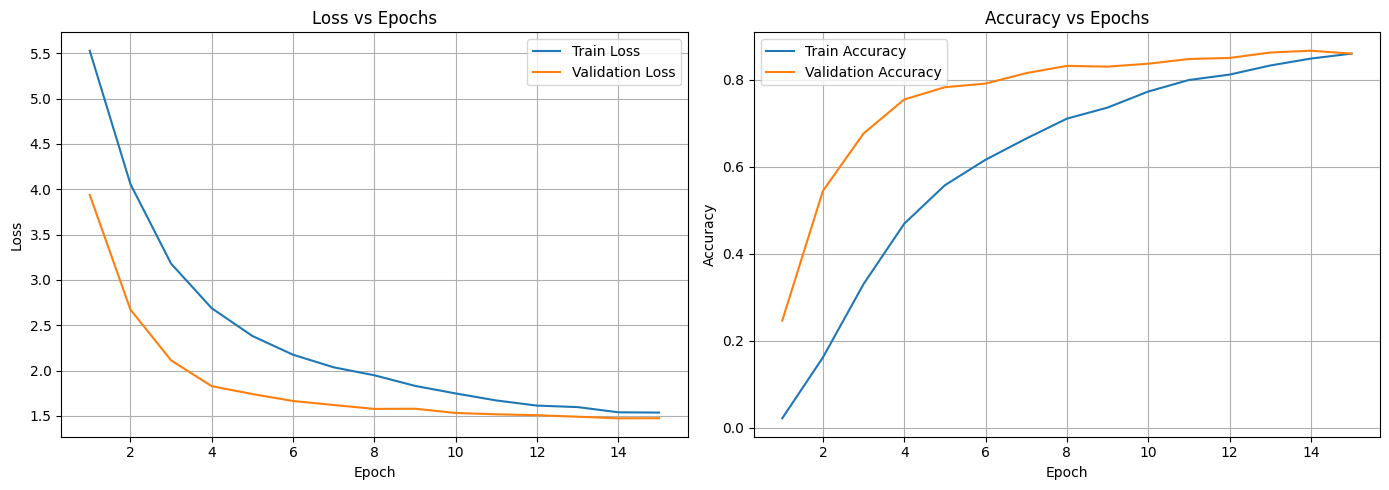

In [ ]:
# --- 4️⃣  Persist and Plot Training History ---
plot_history(history, "/content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2", "training_history_head.png")

## &emsp;&emsp;**6.4 Phase 2 - Fine-Tuning**

> This subsection outlines the Phase 2: Fine-tuning process of the EfficientNetV2-L model, where training resumes from the best-performing head checkpoint obtained in Phase 1. It begins by establishing key file paths for saving model states at various stages, followed by loading the pretrained classifier head to ensure a strong initialisation. A gradual unfreezing schedule (ULMFiT-inspired) is then defined, enabling deeper layers of the network to be progressively trainable, thereby reducing catastrophic forgetting. The fine-tuning setup integrates several advanced optimisation technique: a hybrid loss combining label smoothing and ArcFace for discriminative learning, EMA (Exponential Moving Average) for stability, and SWA (Stochastic Weight Averaging) for smoother convergence. The main training loop employs SAM (Sharpness-Aware Minimisation) with differential learning rates to balance backbone and head updates while monitoring validation loss for early stopping. Throughout the process, training history is logged, checkpoints for the best-performing model are saved, and both EMA and SWA models are finalised for robust inference. Overall, this section ensures the model transitions from a strong head-initialised state to a fully fine-tuned, generalisable representation through structured unfreezing and stability-driven optimisation.

In [ ]:
# --- 0️⃣ Paths & housekeeping ---
# Define key file paths for model saving/loading at different training stages
drive_path = "/content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2"
os.makedirs(drive_path, exist_ok=True)

best_head_path = os.path.join(drive_path, "efficientnetv2_head.pth")  # best head-only model (Stage 1)
fine_tune_best_path = os.path.join(drive_path, "efficientnetv2_finetune.pth") # best fine-tuned model (Stage 2)
swa_final_path = os.path.join(drive_path, "efficientnetv2_swa_final.pth") # final SWA-averaged model

# --- 1️⃣ Load best head checkpoint (trained in Stage 1) ---
print("Loading head checkpoint:", best_head_path)
model.load_state_dict(torch.load(best_head_path, map_location=device))
model.to(device)
print("✅ Head weights loaded and model moved to device.")
# Start fine-tuning from previously trained head weights for faster convergence

# --- 2️⃣ Fine-tuning plan: gradual unfreeze schedule (ULMFiT-like) ---
# Strategy: progressively unfreeze deeper layers of EfficientNetV2 to prevent catastrophic forgetting
stage_epochs = [(3, 5), (6, 5), ("all", 20)]  # (unfreeze_last_n_children or "all", epochs)
total_epochs = sum(e for _, e in stage_epochs)
print(f"Planned gradual-unfreeze schedule: {stage_epochs}  (Total epochs ≈ {total_epochs})")

Planned gradual-unfreeze schedule: [(3, 5), (6, 5), ('all', 20)]  (Total epochs ≈ 30)


In [ ]:
# --- 3️⃣ Loss, EMA, SWA & Optimiser setup ---
num_classes = NUM_CLASSES
EMBED_DIM = 512
feature_dim = EMBED_DIM  # must match embedding size of the custom head

# Use hybrid loss: combines Label-Smoothed CrossEntropy and ArcFace
hybrid_loss = HybridLoss(num_classes=num_classes, smoothing=0.1, arcface_lambda=0.7, feature_dim=feature_dim)
hybrid_loss = hybrid_loss.to(device)

# EMA keeps a moving average of weights — improves generalisation stability
ema = ModelEMA(model, decay=0.999)  # lower decay → faster tracking, higher → smoother averaging

# SWA (Stochastic Weight Averaging) setup for final convergence smoothing
use_swa = True
swa_model = AveragedModel(model) if use_swa else None
swa_start_epoch = int(total_epochs * 0.7)  # enable SWA after ~70% of training
swa_scheduler = None  # will be initialised later with the optimiser

# --- Training bookkeeping ---
history = init_history() # track training/validation performance
best_val_loss = float("inf")
patience = 7 # early stopping patience
epochs_no_improve = 0

In [ ]:
def get_features_and_logits(model, x):
    """
    Retrieves the 512-dim feature embeddings and 200-dim logits from the model.
    Ensures proper handling of the global pooling step before the custom head.

    Returns:
        (features, logits):
            features → 512-D embedding (for ArcFace)
            logits   → 200-D class scores
    """

    # 1. Get the raw output from the backbone layers (4D tensor: B x C x H x W)
    if hasattr(model, "features"):
        # Most torchvision/timm EfficientNetV2 models expose a .features block
        backbone_output = model.features(x)
    elif hasattr(model, "forward_features"):
        # Some timm implementations define a dedicated feature extractor
        backbone_output = model.forward_features(x)
    else:
        # If the structure is unexpected, fall back to direct forward pass
        logits = model(x)
        features = logits.detach() # fallback (not ideal for ArcFace embeddings)
        print("Warning: Model structure unexpected, falling back to logits as features.")
        return features, logits


    # 2. Apply Global Average Pooling and Flattening
    # EfficientNetV2 often uses model.avgpool for this.
    if hasattr(model, "avgpool"):
        # Use model’s native avgpool layer if defined
        pooled_output = model.avgpool(backbone_output)
    else:
        # Otherwise use adaptive pooling to ensure (1x1) spatial output
        pooled_output = F.adaptive_avg_pool2d(backbone_output, 1)

    # Flatten pooled tensor from (B x C x 1 x 1) → (B x C)
    pooled_output = torch.flatten(pooled_output, 1) # Tensor is now (B x 1280)


    # 3. Use the Custom Head to get features (512-dim) and logits (200-dim)
    if hasattr(model, "classifier") and hasattr(model.classifier, "forward_features"):
        # CustomEfficientNetHead exposes a .forward_features() method for ArcFace embeddings
        features = model.classifier.forward_features(pooled_output) # Returns (B x 512)
        logits = model.classifier.classifier(features)             # Returns (B x 200)
        return features, logits

    # 4. Final Fallback (if pooling worked but head structure is unknown)
    # This shouldn't be hit if CustomEfficientNetHead is attached correctly
    logits = model(x)
    features = pooled_output.detach()

    return features, logits

In [ ]:
# --- 5️⃣ Main fine-tuning loop with gradual unfreezing ---
# This stage progressively unfreezes layers of the EfficientNetV2 backbone (ULMFiT-inspired)
# while applying differential learning rates and SAM-based optimization for stable fine-tuning.
global_epoch = 0
for unfreeze_spec, n_epochs in stage_epochs:
    # Unfreeze specified portion
    if unfreeze_spec == "all":
        # fully unfreeze
        set_parameter_requires_grad(model, requires_grad=True)
        print("🔓 Entire model unfrozen for final fine-tuning phase.")
    else:
        # unfreeze last N children/blocks from features or top-level if features doesn't exist
        print(f"🔓 Unfreezing last {unfreeze_spec} child modules of backbone.")
        unfreeze_backbone_layers(model, unfreeze_last_n_children=unfreeze_spec)

    # Display how many parameters are now trainable
    trainable, total = count_trainable_parameters(model)
    print(f"Trainable params now: {trainable:,} / {total:,} ({trainable/total:.2%})")

    # Build differential LR param groups: lower LR for backbone, higher for head
    # Recommended: base_lr (backbone) small (1e-5), head_lr (new head) larger (1e-4 to 1e-3 depending)
    base_lr = 1e-5
    head_lr = 1e-4
    param_groups = build_param_groups(model, base_lr=base_lr, head_lr=head_lr)

    # SAM with AdamW base optimiser; pass param_groups to SAM
    base_optimiser = torch.optim.AdamW
    sam_optimiser = SAM(param_groups, base_optimiser, rho=0.05, adaptive=False, weight_decay=1e-4)

    # Scheduler: cosine annealing on the base optimiser (use a relatively slow decay)
    # We will re-create a scheduler mapping to the base optimiser: sam_optimiser.base_optimiser
    stage_total_epochs = n_epochs
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(sam_optimiser.base_optimiser, T_max=max(stage_total_epochs, 1))

    # SWA scheduler must be constructed against the base optimiser as well
    if use_swa:
        swa_scheduler = SWALR(sam_optimiser.base_optimiser, swa_lr=5e-6)

    # Optionally freeze BatchNorm running stats if small batches
    set_bn_eval(model)

    # Epoch loop for this stage
    for epoch_in_stage in range(1, stage_total_epochs + 1):
        global_epoch += 1
        print(f"\n=== Fine-tune Global Epoch {global_epoch} (Stage epoch {epoch_in_stage}/{stage_total_epochs}) ===")

        # TRAIN (SAM: manual two-step)
        model.train()
        running_loss, correct, total_samples = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"FineTune Epoch {global_epoch}", leave=False)
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward features & logits
            features, logits = get_features_and_logits(model, images)

            # Hybrid loss requires features (for ArcFace) and logits (for standard CE)
            loss = hybrid_loss(features, logits, labels)

            # SAM step 1
            sam_optimiser.zero_grad()
            loss.backward()
            sam_optimiser.first_step(zero_grad=True)

            # SAM step 2: recompute loss & step
            # recompute features/logits on perturbed weights
            features_2, logits_2 = get_features_and_logits(model, images)
            loss2 = hybrid_loss(features_2, logits_2, labels)
            loss2.backward()
            sam_optimiser.second_step(zero_grad=True)

            # Update EMA after optimiser step
            ema.update(model)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(logits.detach(), 1)
            correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            pbar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = running_loss / total_samples
        train_acc = correct / total_samples

        # VALIDATION
        # Uses standard CE loss for reporting; HybridLoss only used for training.
        val_loss, val_acc, val_class_acc = validate(model, val_loader, criterion=nn.CrossEntropyLoss(label_smoothing=0.0), device=device, num_classes=num_classes)
        # Note: validate currently uses standard CE; we report Top-1 and per-class average. HybridLoss is used in training only.

        # Bookkeeping
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_per_class_acc"].append(val_class_acc)

        print(f"📉 Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"🧪 Val Loss:   {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% (Avg/Class: {val_class_acc*100:.2f}%)")

        # Scheduler step (use SWA scheduler after swa_start_epoch)
        if global_epoch > swa_start_epoch and use_swa:
            # update SWA model & step its scheduler
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()

        # Checkpoint: Save best (based on val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save both raw model state and EMA state for robustness
            torch.save(model.state_dict(), fine_tune_best_path)
            # Also save EMA snapshot
            try:
                torch.save(ema.state_dict(), os.path.join(drive_path, "efficientnetv2_finetune_ema.pth"))
            except Exception:
                # ModelEMA has .ema_model — save that
                torch.save(ema.ema_model.state_dict(), os.path.join(drive_path, "efficientnetv2_finetune_ema.pth"))
            print(f"💾 New best fine-tuned model saved → {fine_tune_best_path}")
        else:
            epochs_no_improve += 1
            print(f"⏳ Early stopping counter: {epochs_no_improve}/{patience}")
            if epochs_no_improve >= patience:
                print("🛑 Early stopping triggered — ending fine-tuning.")
                break

        # Save intermediate history each epoch
        save_training_history(history, drive_path, "training_history_finetune.json")

    # End of stage; if early stopping occurred, break outer loop
    if epochs_no_improve >= patience:
        break

🔓 Unfreezing last 3 child modules of backbone.
Updated trainable params: 100,014,344 / 117,993,768 (84.76%)
Trainable params now: 100,014,344 / 117,993,768 (84.76%)

=== Fine-tune Global Epoch 1 (Stage epoch 1/5) ===


📉 Train Loss: 6.7606 | Train Acc: 85.40%
🧪 Val Loss:   0.5801 | Val Acc: 86.13% (Avg/Class: 85.78%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 2 (Stage epoch 2/5) ===


📉 Train Loss: 6.6089 | Train Acc: 86.27%
🧪 Val Loss:   0.5643 | Val Acc: 86.63% (Avg/Class: 86.56%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 3 (Stage epoch 3/5) ===


📉 Train Loss: 6.4907 | Train Acc: 87.31%
🧪 Val Loss:   0.5589 | Val Acc: 86.88% (Avg/Class: 86.83%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 4 (Stage epoch 4/5) ===


📉 Train Loss: 6.4184 | Train Acc: 87.45%
🧪 Val Loss:   0.5595 | Val Acc: 86.38% (Avg/Class: 86.20%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 5 (Stage epoch 5/5) ===


📉 Train Loss: 6.3895 | Train Acc: 88.28%
🧪 Val Loss:   0.5511 | Val Acc: 86.88% (Avg/Class: 86.72%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json
🔓 Unfreezing last 6 child modules of backbone.
Updated trainable params: 116,922,376 / 117,993,768 (99.09%)
Trainable params now: 116,922,376 / 117,993,768 (99.09%)

=== Fine-tune Global Epoch 6 (Stage epoch 1/5) ===


📉 Train Loss: 6.3366 | Train Acc: 86.83%
🧪 Val Loss:   0.5680 | Val Acc: 86.79% (Avg/Class: 86.64%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 7 (Stage epoch 2/5) ===


📉 Train Loss: 6.2030 | Train Acc: 87.76%
🧪 Val Loss:   0.5562 | Val Acc: 86.79% (Avg/Class: 86.62%)
⏳ Early stopping counter: 2/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 8 (Stage epoch 3/5) ===


📉 Train Loss: 6.0814 | Train Acc: 88.11%
🧪 Val Loss:   0.5635 | Val Acc: 86.38% (Avg/Class: 86.23%)
⏳ Early stopping counter: 3/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 9 (Stage epoch 4/5) ===


📉 Train Loss: 6.0117 | Train Acc: 89.13%
🧪 Val Loss:   0.5712 | Val Acc: 86.88% (Avg/Class: 86.53%)
⏳ Early stopping counter: 4/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 10 (Stage epoch 5/5) ===


📉 Train Loss: 5.9803 | Train Acc: 89.15%
🧪 Val Loss:   0.5670 | Val Acc: 86.46% (Avg/Class: 86.15%)
⏳ Early stopping counter: 5/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json
🔓 Entire model unfrozen for final fine-tuning phase.
Trainable params now: 117,993,768 / 117,993,768 (100.00%)

=== Fine-tune Global Epoch 11 (Stage epoch 1/20) ===


📉 Train Loss: 5.9388 | Train Acc: 88.53%
🧪 Val Loss:   0.5455 | Val Acc: 86.96% (Avg/Class: 86.71%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 12 (Stage epoch 2/20) ===


📉 Train Loss: 5.8128 | Train Acc: 88.55%
🧪 Val Loss:   0.5609 | Val Acc: 86.05% (Avg/Class: 85.80%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 13 (Stage epoch 3/20) ===


📉 Train Loss: 5.6865 | Train Acc: 90.06%
🧪 Val Loss:   0.5474 | Val Acc: 86.79% (Avg/Class: 86.65%)
⏳ Early stopping counter: 2/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 14 (Stage epoch 4/20) ===


📉 Train Loss: 5.5731 | Train Acc: 90.45%
🧪 Val Loss:   0.5613 | Val Acc: 87.29% (Avg/Class: 87.02%)
⏳ Early stopping counter: 3/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 15 (Stage epoch 5/20) ===


📉 Train Loss: 5.4572 | Train Acc: 90.45%
🧪 Val Loss:   0.5431 | Val Acc: 86.71% (Avg/Class: 86.40%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 16 (Stage epoch 6/20) ===


📉 Train Loss: 5.3576 | Train Acc: 91.05%
🧪 Val Loss:   0.5517 | Val Acc: 87.13% (Avg/Class: 86.90%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 17 (Stage epoch 7/20) ===


📉 Train Loss: 5.2546 | Train Acc: 91.51%
🧪 Val Loss:   0.5300 | Val Acc: 87.13% (Avg/Class: 86.79%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 18 (Stage epoch 8/20) ===


📉 Train Loss: 5.1501 | Train Acc: 91.68%
🧪 Val Loss:   0.5289 | Val Acc: 86.38% (Avg/Class: 86.26%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 19 (Stage epoch 9/20) ===


📉 Train Loss: 5.0619 | Train Acc: 92.75%
🧪 Val Loss:   0.5278 | Val Acc: 86.79% (Avg/Class: 86.58%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 20 (Stage epoch 10/20) ===


📉 Train Loss: 4.9921 | Train Acc: 92.13%
🧪 Val Loss:   0.5261 | Val Acc: 86.88% (Avg/Class: 86.69%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 21 (Stage epoch 11/20) ===


📉 Train Loss: 4.9198 | Train Acc: 93.37%
🧪 Val Loss:   0.5239 | Val Acc: 86.54% (Avg/Class: 86.32%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 22 (Stage epoch 12/20) ===


📉 Train Loss: 4.8566 | Train Acc: 93.17%
🧪 Val Loss:   0.5177 | Val Acc: 87.54% (Avg/Class: 87.31%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 23 (Stage epoch 13/20) ===


📉 Train Loss: 4.8058 | Train Acc: 93.02%
🧪 Val Loss:   0.5209 | Val Acc: 87.21% (Avg/Class: 87.03%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 24 (Stage epoch 14/20) ===


📉 Train Loss: 4.7535 | Train Acc: 93.91%
🧪 Val Loss:   0.5130 | Val Acc: 87.46% (Avg/Class: 87.36%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 25 (Stage epoch 15/20) ===


📉 Train Loss: 4.6967 | Train Acc: 94.35%
🧪 Val Loss:   0.5077 | Val Acc: 87.46% (Avg/Class: 87.29%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 26 (Stage epoch 16/20) ===


📉 Train Loss: 4.6569 | Train Acc: 94.39%
🧪 Val Loss:   0.5141 | Val Acc: 87.21% (Avg/Class: 87.01%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 27 (Stage epoch 17/20) ===


📉 Train Loss: 4.6007 | Train Acc: 94.37%
🧪 Val Loss:   0.5080 | Val Acc: 87.54% (Avg/Class: 87.25%)
⏳ Early stopping counter: 2/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 28 (Stage epoch 18/20) ===


📉 Train Loss: 4.5783 | Train Acc: 94.89%
🧪 Val Loss:   0.4974 | Val Acc: 88.04% (Avg/Class: 87.87%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 29 (Stage epoch 19/20) ===


📉 Train Loss: 4.5445 | Train Acc: 94.66%
🧪 Val Loss:   0.4946 | Val Acc: 88.70% (Avg/Class: 88.46%)
💾 New best fine-tuned model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune.pth
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json

=== Fine-tune Global Epoch 30 (Stage epoch 20/20) ===


📉 Train Loss: 4.5309 | Train Acc: 94.49%
🧪 Val Loss:   0.5118 | Val Acc: 87.21% (Avg/Class: 86.96%)
⏳ Early stopping counter: 1/7
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json


In [ ]:
# --- 6️⃣ Finalise SWA (if used) and EMA merge ---
if use_swa and swa_model is not None:
    print("\n🔄 Finalising SWA: updating BatchNorm statistics using train_loader...")
    update_bn(train_loader, swa_model, device=device)
    torch.save(swa_model.module.state_dict(), swa_final_path)
    print(f"✅ SWA-averaged model saved → {swa_final_path}")

# Also optionally save EMA model as final inference model
try:
    ema_out_path = os.path.join(drive_path, "efficientnetv2_finetune_ema_final.pth")
    # EMA holds the smoothed version in .ema_model
    torch.save(ema.ema_model.state_dict(), ema_out_path)
    print(f"✅ EMA model saved → {ema_out_path}")
except Exception as e:
    # A soft fail here is acceptable since the SWA model is the primary target
    print(f"⚠️ Warning: Failed to save final EMA model: {e}")


🔄 Finalising SWA: updating BatchNorm statistics using train_loader...
✅ SWA-averaged model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_swa_final.pth
✅ EMA model saved → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_finetune_ema_final.pth



✅ Fine-tuning completed.
Best validation loss observed: 0.4946
✅ Training history saved to: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.json
📊 Saved training history plot to /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/training_history_finetune.png


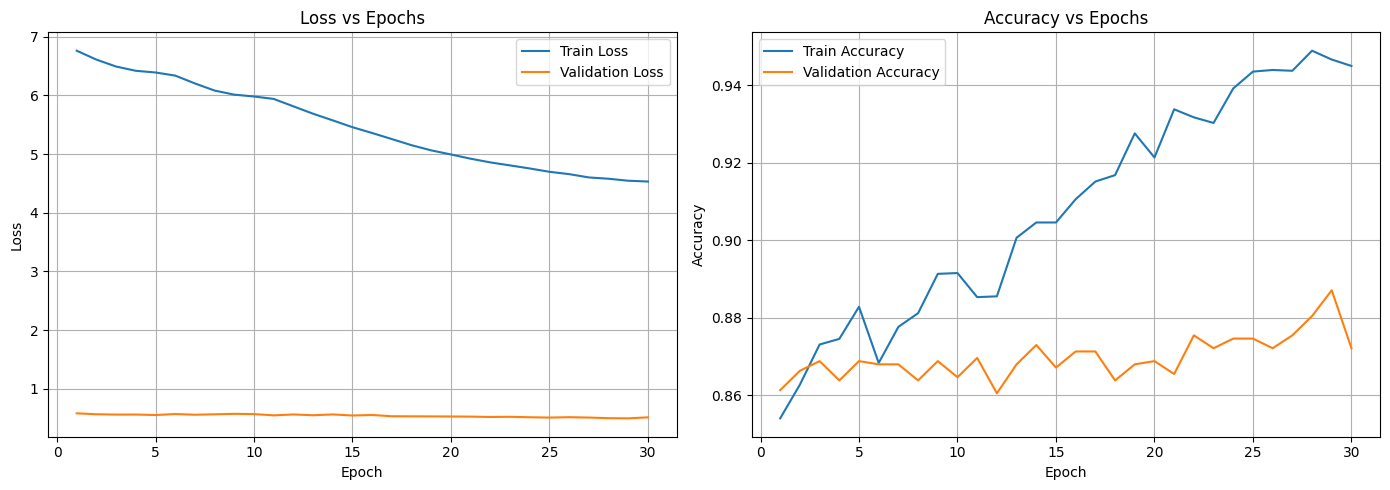

In [ ]:
# --- 7️⃣ Final bookkeeping & plot ---
print("\n✅ Fine-tuning completed.")
print(f"Best validation loss observed: {best_val_loss:.4f}")
save_training_history(history, drive_path, "training_history_finetune.json")
plot_history(history, "/content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2", "training_history_finetune.png")

## &emsp;&emsp;**6.5 Result Analysis**

> This final subsection focuses on the evaluation and analysis of the fine-tuned EfficientNetV2-L model. After defining output paths and restoring the best-performing checkpoint, the model is transferred to the appropriate device and set to evaluation mode for deterministic inference. Predictions are then generated on the held-out test set (previously used only for validation and performance visualisation), with class probabilities computed via softmax to derive metrics such as Top-1 and Top-5 accuracy, weighted precision, recall, F1-score, and average per-class accuracy. Results are saved in both CSV and JSON formats for transparency and reproducibility. A normalised confusion matrix is plotted to visualise misclassifications, revealing inter-class confusions, while the bottom-10 classes by F1-score are identified to highlight the model's weakest categories. Together, these analyses provide a comprehensive understanding of the model's generalisation ability, performance consistency, and class-level behavior.

In [ ]:
# --- 0️⃣ Configuration ---
drive_path = "/content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2"
best_model_path = f"{drive_path}/efficientnetv2_swa_final.pth"
confmat_path = f"{drive_path}/efficientnetv2_confusion_matrix.png"
metrics_table_path = f"{drive_path}/efficientnetv2_metrics_table.csv"
metrics_summary_path = f"{drive_path}/efficientnetv2_metrics_summary.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- 1️⃣ Load Model ---
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

print(f"✅ Loaded best fine-tuned model from: {best_model_path}")

Device: cuda
✅ Loaded best fine-tuned model from: /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_swa_final.pth


In [ ]:
# --- 2️⃣ Run inference on test set ---
# Once the best fine-tuned model is loaded, we evaluate its performance on the test (validation) set.
# This step generates predictions, ground truth labels, and softmax probabilities for later analysis (e.g., confusion matrix, ROC, etc.).

all_preds = []
all_targets = []
all_probs = []

# The same DataLoader (val_loader) is reused as test_loader,
# since the test set is reserved exclusively for evaluation and visualisation.
test_loader = val_loader

# Disable gradient computation for faster inference and lower memory usage
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # Forward pass through the model
        probs = F.softmax(outputs, dim=1) # Convert raw logits into class probabilities
        preds = torch.argmax(probs, dim=1) # Predicted class is the index with maximum probability

        # Store predictions, true labels, and probability vectors
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert collected lists to numpy arrays for evaluation metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
all_probs = np.array(all_probs)

In [ ]:
# --- 3️⃣ Compute Metrics ---
acc = accuracy_score(all_targets, all_preds)
top5 = top_k_accuracy_score(all_targets, all_probs, k=5)
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')
avg_per_class_acc = calculate_average_per_class_accuracy(all_targets, all_preds, num_classes=NUM_CLASSES)

print("\n=== 🧮 Overall Performance Metrics ===")
print(f"Top-1 Accuracy : {acc*100:.2f}%")
print(f"Top-5 Accuracy : {top5*100:.2f}%")
print(f"Avg Per-Class Accuracy: {avg_per_class_acc*100:.2f}%")
print(f"Precision (weighted): {precision*100:.2f}%")
print(f"Recall (weighted):    {recall*100:.2f}%")
print(f"F1-score (weighted):  {f1*100:.2f}%")

# Per-class breakdown
class_report = classification_report(all_targets, all_preds, output_dict=True, zero_division=0)
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv(metrics_table_path)
print(f"\n📊 Per-class metrics saved to → {metrics_table_path}")

# Summary JSON
summary = {
    "top1_accuracy": acc,
    "top5_accuracy": top5,
    "avg_per_class_accuracy": avg_per_class_acc,
    "precision_weighted": precision,
    "recall_weighted": recall,
    "f1_weighted": f1
}
with open(metrics_summary_path, "w") as f:
    json.dump(summary, f, indent=4)
print(f"📁 Summary JSON saved to → {metrics_summary_path}")


=== 🧮 Overall Performance Metrics ===
Top-1 Accuracy : 88.12%
Top-5 Accuracy : 97.84%
Avg Per-Class Accuracy: 87.89%
Precision (weighted): 89.40%
Recall (weighted):    88.12%
F1-score (weighted):  87.99%

📊 Per-class metrics saved to → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_metrics_table.csv
📁 Summary JSON saved to → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_metrics_summary.json


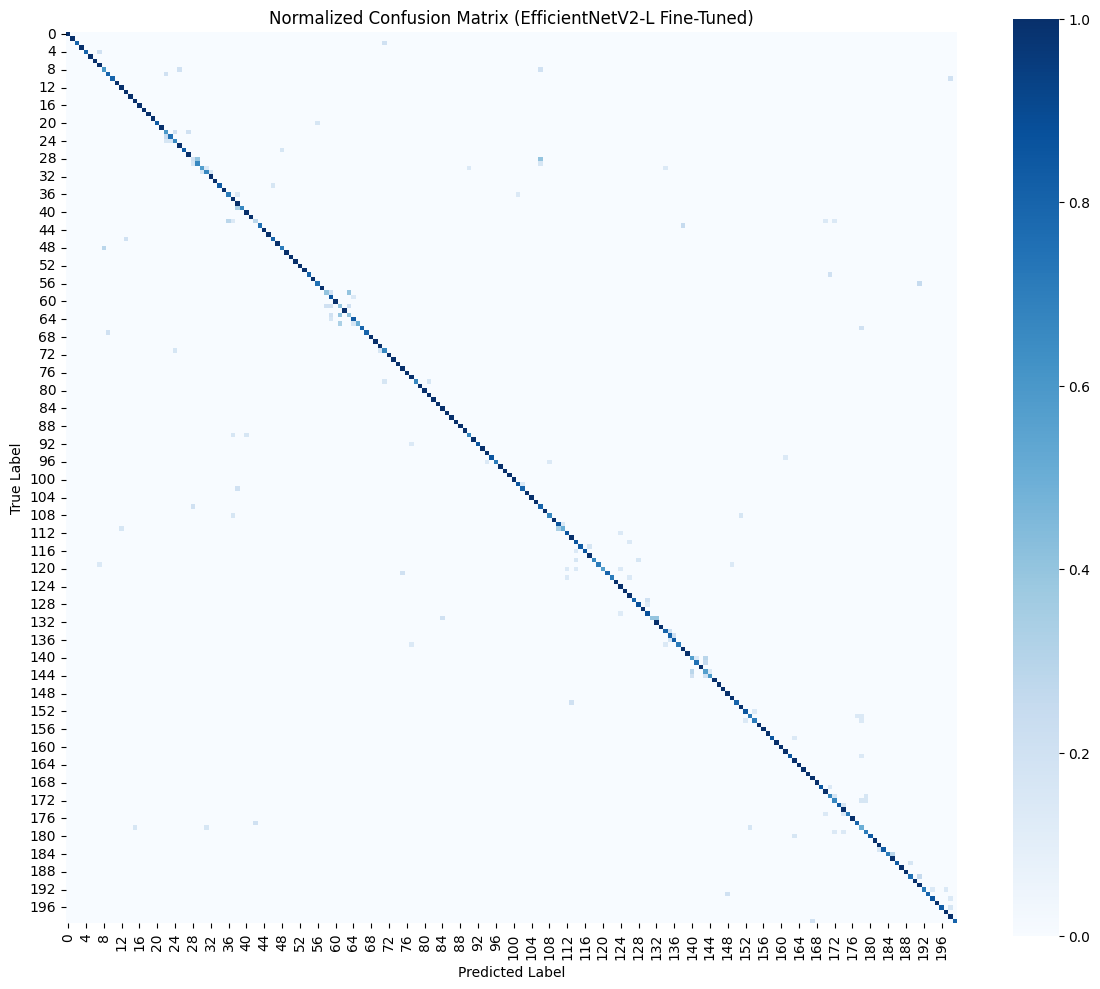

🖼️ Confusion matrix saved to → /content/drive/MyDrive/COS30082 Applied Machine Learning/EfficientNetV2/efficientnetv2_confusion_matrix.png


In [ ]:
# --- 4️⃣ Confusion Matrix ---
cm = confusion_matrix(all_targets, all_preds)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, cmap="Blues", square=True, cbar=True)
plt.title("Normalized Confusion Matrix (EfficientNetV2-L Fine-Tuned)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig(confmat_path, dpi=300)
plt.show()
print(f"🖼️ Confusion matrix saved to → {confmat_path}")

In [ ]:
# --- 5️⃣ Show worst-performing classes ---

worst_classes = (
    class_report_df[class_report_df.index.str.isnumeric()]
    .sort_values("f1-score", ascending=True)
    .head(10)
)

# Format the relevant columns as percentages
worst_classes['precision'] = worst_classes['precision'].apply(lambda x: f"{x*100:.2f}%")
worst_classes['recall'] = worst_classes['recall'].apply(lambda x: f"{x*100:.2f}%")
worst_classes['f1-score'] = worst_classes['f1-score'].apply(lambda x: f"{x*100:.2f}%")

print("\n😕 Bottom-10 Classes by F1-score:")
display(worst_classes)


😕 Bottom-10 Classes by F1-score:


,precision,recall,f1-score,support
28,33.33%,20.00%,25.00%,5.0
61,33.33%,40.00%,36.36%,5.0
42,66.67%,28.57%,40.00%,7.0
63,40.00%,40.00%,40.00%,5.0
178,37.50%,50.00%,42.86%,6.0
58,66.67%,40.00%,50.00%,5.0
143,50.00%,57.14%,53.33%,7.0
22,50.00%,60.00%,54.55%,5.0
131,100.00%,40.00%,57.14%,5.0
140,57.14%,57.14%,57.14%,7.0
